# Surrogate testing for behaviour of ant colonies

## Notes

Hypotheses to Test

- **Directional Homogeneity Across Time:**

- Hypothesis: Ant movement directions (represented by angle data) are uniformly distributed and do not change predictably over time.
- Surrogate Data: Generate surrogate datasets by randomly shuffling the angle data across all time points, breaking any temporal dependency but keeping the distribution of angles.


- **Speed Consistency Within and Across Ants:**

- Hypothesis: The speed of ants does not vary significantly between different ants or within the same ant over time.
- Surrogate Data: You can randomize the speed entries across all ants or within each ant to create surrogate datasets that maintain the overall statistical properties (like mean and variance) but lack any intrinsic patterns related to specific ants or time periods.


- **Spatial Distribution and Interaction:**

- Hypothesis: Ants distribute themselves randomly within a given space, without any particular patterns or clustering.
- Surrogate Data: Randomize the (x, y) positions of the ants either completely or within constrained regions (to maintain plausible movements) to test for non-random clustering or pathways.


Steps to Conduct Surrogate Testing

- Select Your Hypothesis: Decide on which aspect of the ants' behavior you are most interested in. This will determine what kind of data randomization is necessary.
- Generate Surrogate Data: Based on the selected hypothesis, generate multiple surrogate datasets. For example, if testing for directional homogeneity, shuffle the angle data while keeping other parameters constant.
- Statistical Analysis:
Calculate statistics relevant to your hypothesis for both the observed and surrogate datasets (e.g., mean, variance, clustering indices, autocorrelation).
Compare these statistics using tests like t-tests, chi-square tests, or more complex models like regression analysis if applicable.
- Interpret Results: Determine whether there are significant differences between the statistics from your observed dataset and the surrogate datasets. Significant differences suggest non-random structures or behaviors in your data.
- Report Findings: Present your methodology, analysis, and conclusions. Discuss possible biological implications of your findings regarding ant behavior and colony dynamics.

## Plan

- Extract 1 dimensional metrics for either individual behaviour or collective behaviour, from individual x y coordinates.
Generate appropiate data for surrogate testing

- Metrics 
Collective centre of mass shift amplitude
number of clusters of given radius / total number of ants in clusters / total number of ants without other ant in certain radius

- Surrogate data
by AAFT - surrogate data must have the same autocorrelation to account for spatio temporal nature of the observed data - CoM shift
or data shuffling - cluster property comparisons

- We gonna know whether collective movement behaviours occur at size and rate of chance (chance given certain assumptions that defined the generated data)






extract measures - test against random
number of ant clusters
total distance between ants




## Setup

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from os.path import join

In [56]:
from data_functions import get_ant_datafiles_info, preprocess_antcolony_data
import multiSyncPy


## Extract new features

In [57]:
def get_nth_colony(n):
    ant_data = get_ant_datafiles_info()
    df = preprocess_antcolony_data(ant_data['file'][n])
    return df


In [58]:
def add_features(df):
    
    # center of mass of the whole ant colony at each frame
    centers_of_mass = df.groupby('frameno')[['x', 'y']].mean().reset_index()
    df = df.merge(centers_of_mass, on='frameno', suffixes=('', '_CoM'))
    
    # distance to center of mass of each ant at each frame
    df['distance_to_CoM'] = np.sqrt((df['x'] - df['x_CoM'])**2 + (df['y'] - df['y_CoM'])**2)

    # polar coordinates of each ant with respect to the origin of cartesian coordinates
    df['polar_dist'] = np.sqrt(df['x']**2 + df['y']**2)
    df['polar_angle'] = np.arctan2(df['y'], df['x'])
    # Convert angle from radians to degrees
    # df['polar_angle'] = np.degrees(df['polar_angle'])

    close_ants_count = df.groupby('frameno').apply(count_close_ants)
    close_ants_count_df = close_ants_count.reset_index()
    close_ants_count_df.columns = ['frameno', 'close_ants_count']

    return df


def count_close_ants(group):
    # Extract coordinates
    coordinates = group[['x', 'y']].to_numpy()
    n = len(coordinates)
    close_count = 0
    
    # Calculate pairwise distances
    for i in range(n):
        # Compute distances from the ith ant to all other ants
        distances = np.sqrt(np.sum((coordinates - coordinates[i])**2, axis=1))
        
        # Check if there is at least one ant closer than 20 units, excluding the ant itself
        if np.any((distances > 0) & (distances < 100)):
            close_count += 1
    
    return close_count   
    

In [59]:
colonies = [ ]
for i in range (10):
    colonies.append(f'df{i}')
    exec(f'df{i} = get_nth_colony({i})')
    exec(f'df{i} = add_features(df{i})')

/tmp/ipykernel_869753/2498914397.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  close_ants_count = df.groupby('frameno').apply(count_close_ants)
/tmp/ipykernel_869753/2498914397.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  close_ants_count = df.groupby('frameno').apply(count_close_ants)
/tmp/ipykernel_869753/2498914397.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

## Plots

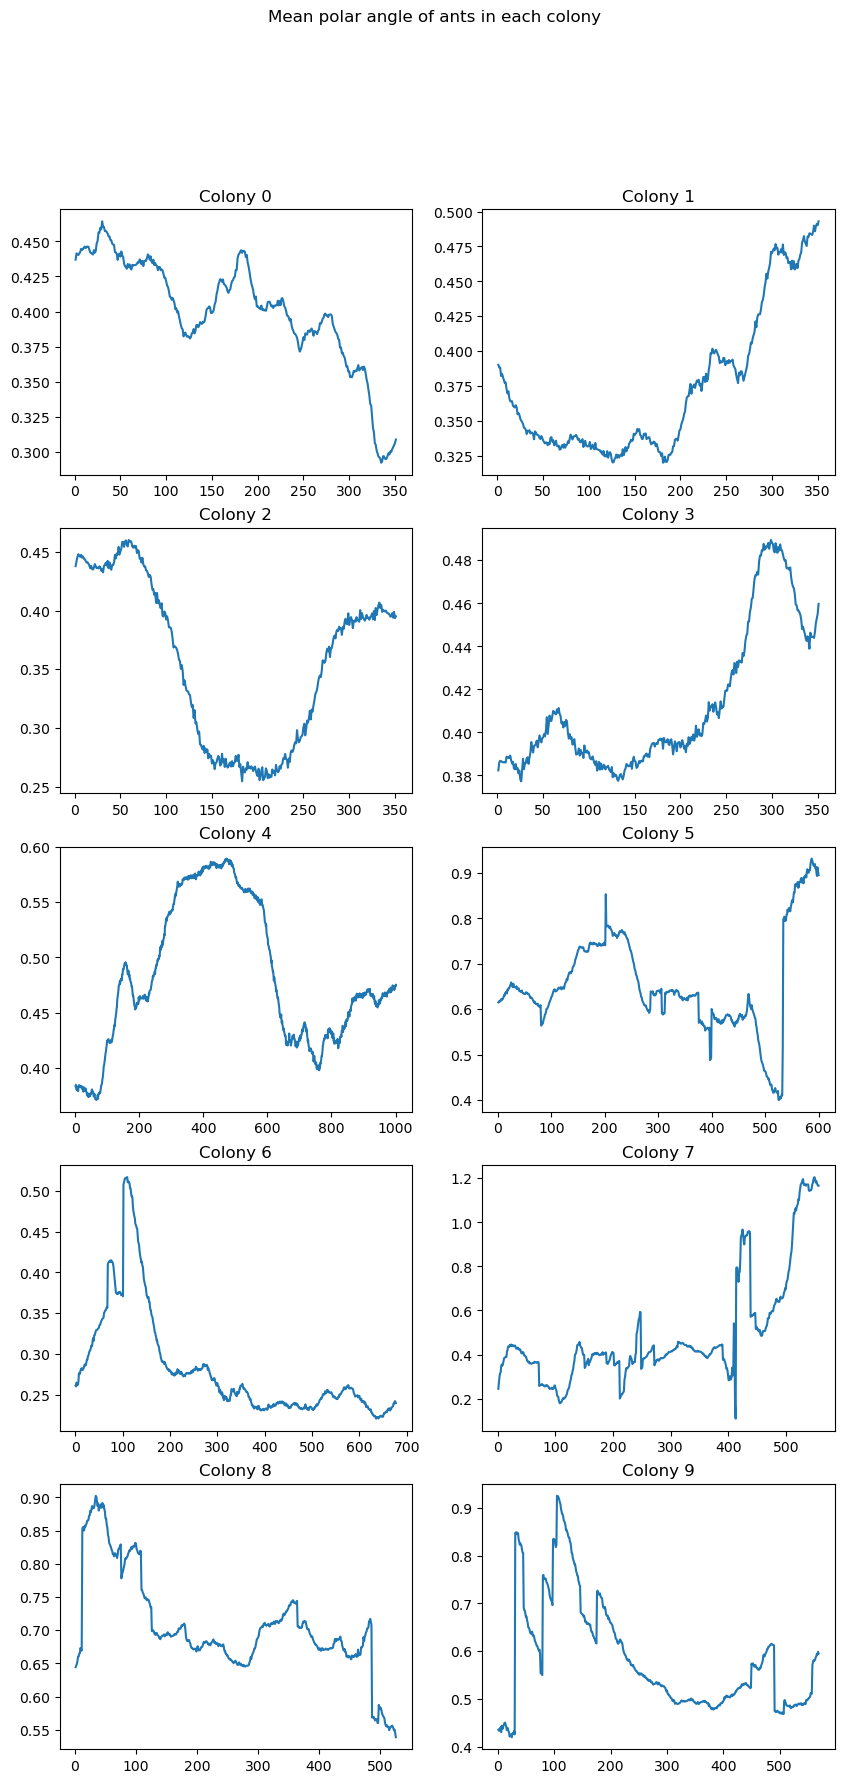

0       0.539552
1       0.332519
2       0.534130
3       0.332855
4       0.532343
          ...   
4661    1.441624
4662    0.320103
4663    0.245832
4664    0.779653
4665    0.448639
Name: polar_angle, Length: 4666, dtype: float64

In [60]:
plt.figure(figsize=(10, 20))
for i in range(10):
    exec(f'df = df{i}')
    plt.subplot(5, 2, i+1)
    plt.title(f'Colony {i}')
    plt.plot(df.groupby('frameno')['polar_angle'].mean())
plt.suptitle('Mean polar angle of ants in each colony')
plt.show()

display(df.groupby('frameno')['polar_angle'].head(10))

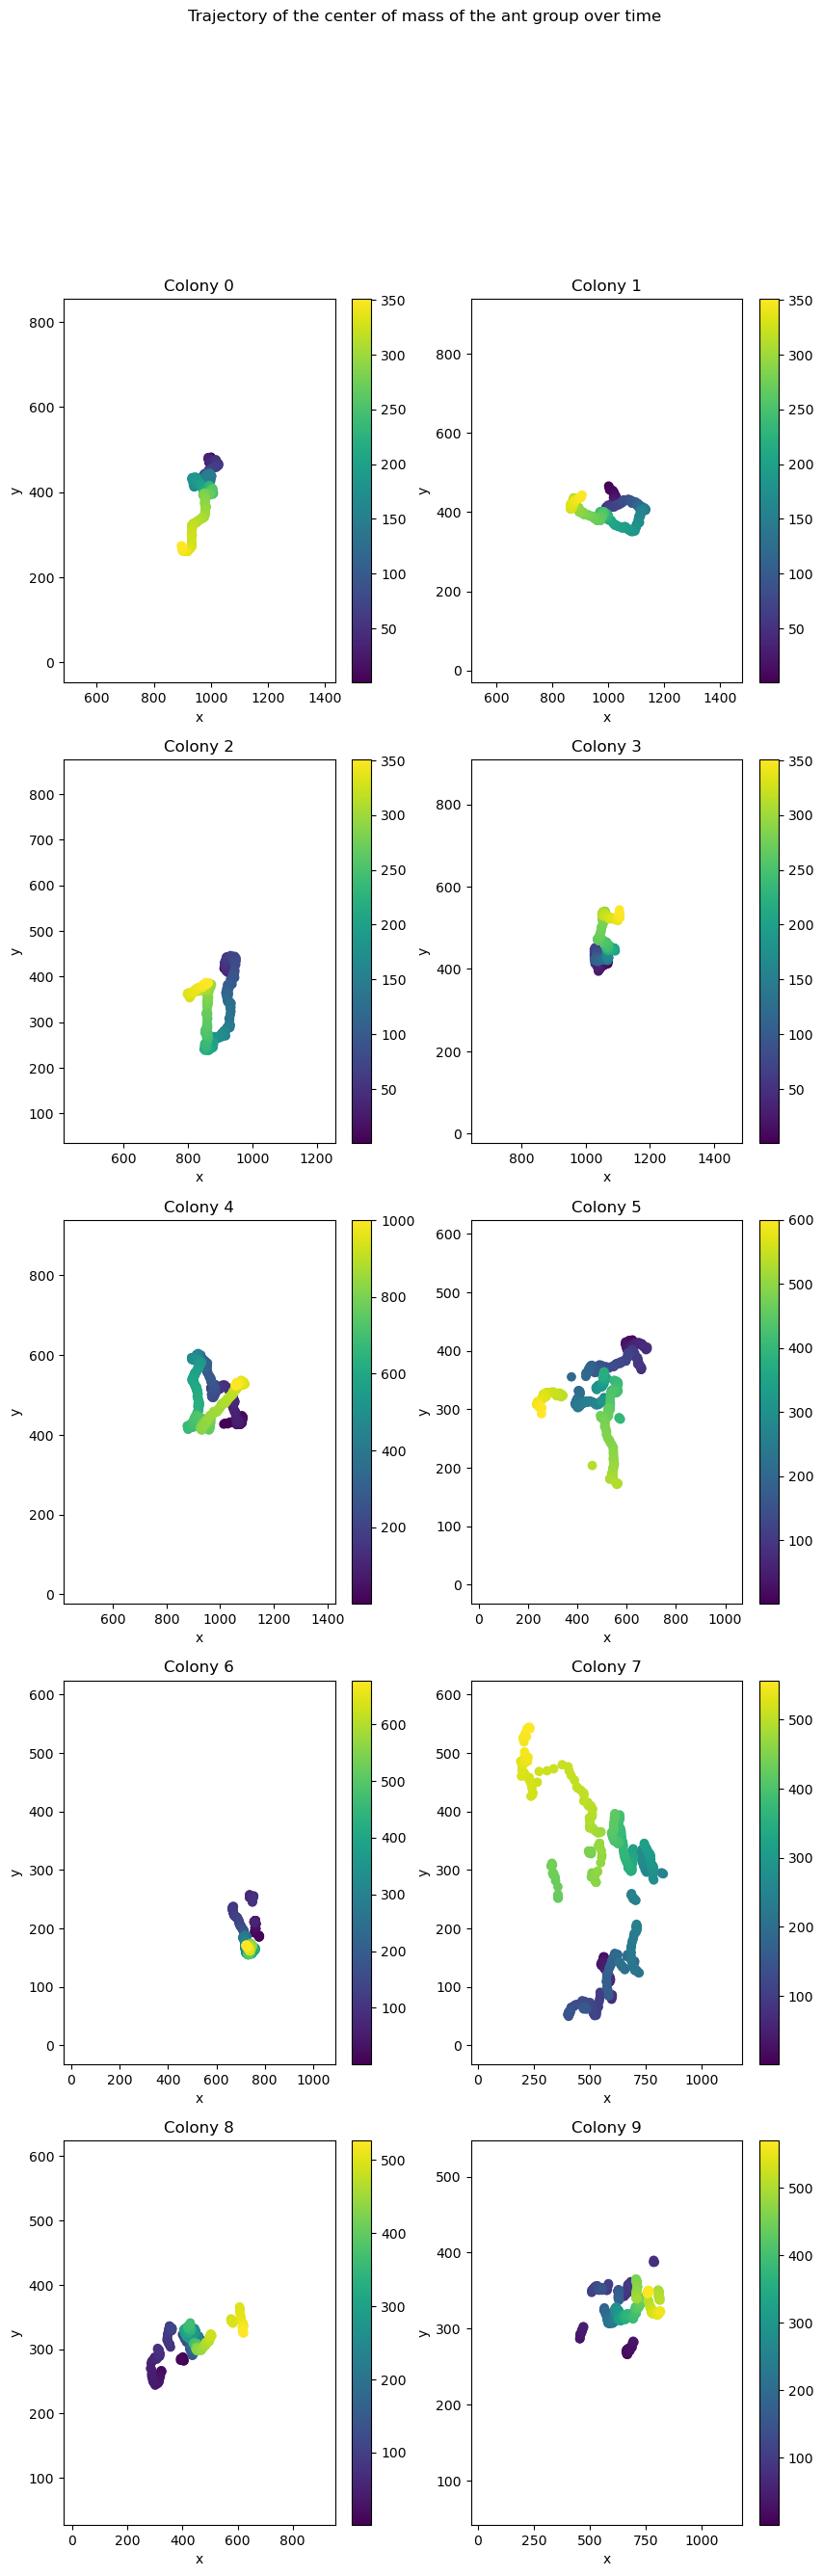

In [61]:
plt.figure(figsize=(10, 30))
for i in range(10):
    exec(f'df = df{i}')
    centers_of_mass = df.groupby('frameno')[['x', 'y']].mean().reset_index()
    plt.subplot(5, 2, i+1)
    plt.title(f'Colony {i}')
    plt.scatter(centers_of_mass['x'], centers_of_mass['y'], c=centers_of_mass['frameno'])
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(df['x'].min(), df['x'].max())
    plt.ylim(df['y'].min(), df['y'].max())

plt.suptitle('Trajectory of the center of mass of the ant group over time')
plt.show()

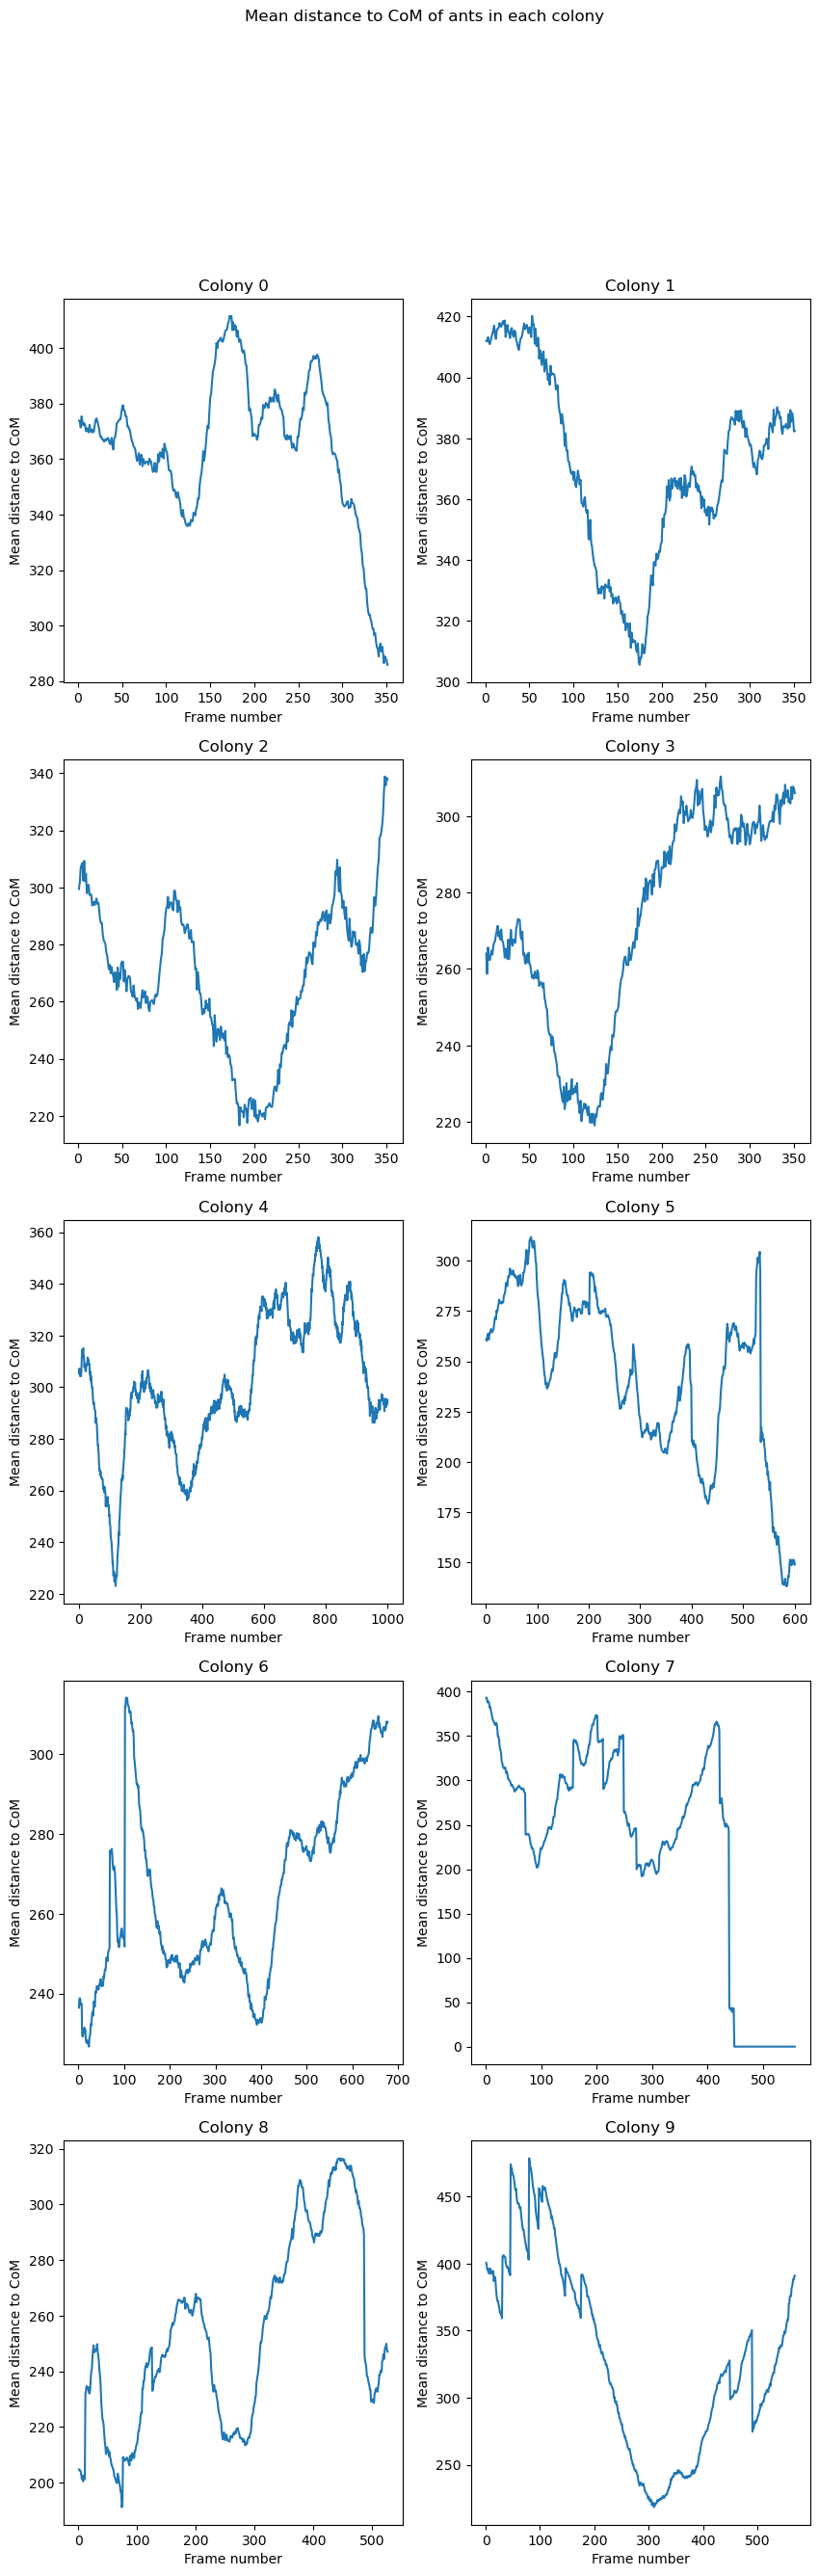

In [62]:
plt.figure(figsize=(10, 30))
for i in range(10):
    exec(f'df = df{i}')
    plt.subplot(5, 2, i+1)
    plt.title(f'Colony {i}')
    mean_distance = df.groupby('frameno')['distance_to_CoM'].mean().reset_index()
    plt.plot(mean_distance['frameno'], mean_distance['distance_to_CoM'])
    plt.xlabel('Frame number')
    plt.ylabel('Mean distance to CoM')
plt.suptitle('Mean distance to CoM of ants in each colony')
plt.show()


/tmp/ipykernel_869753/3085975008.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  close_ants_count = df.groupby('frameno').apply(count_close_ants)
/tmp/ipykernel_869753/3085975008.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  close_ants_count = df.groupby('frameno').apply(count_close_ants)
/tmp/ipykernel_869753/3085975008.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping col

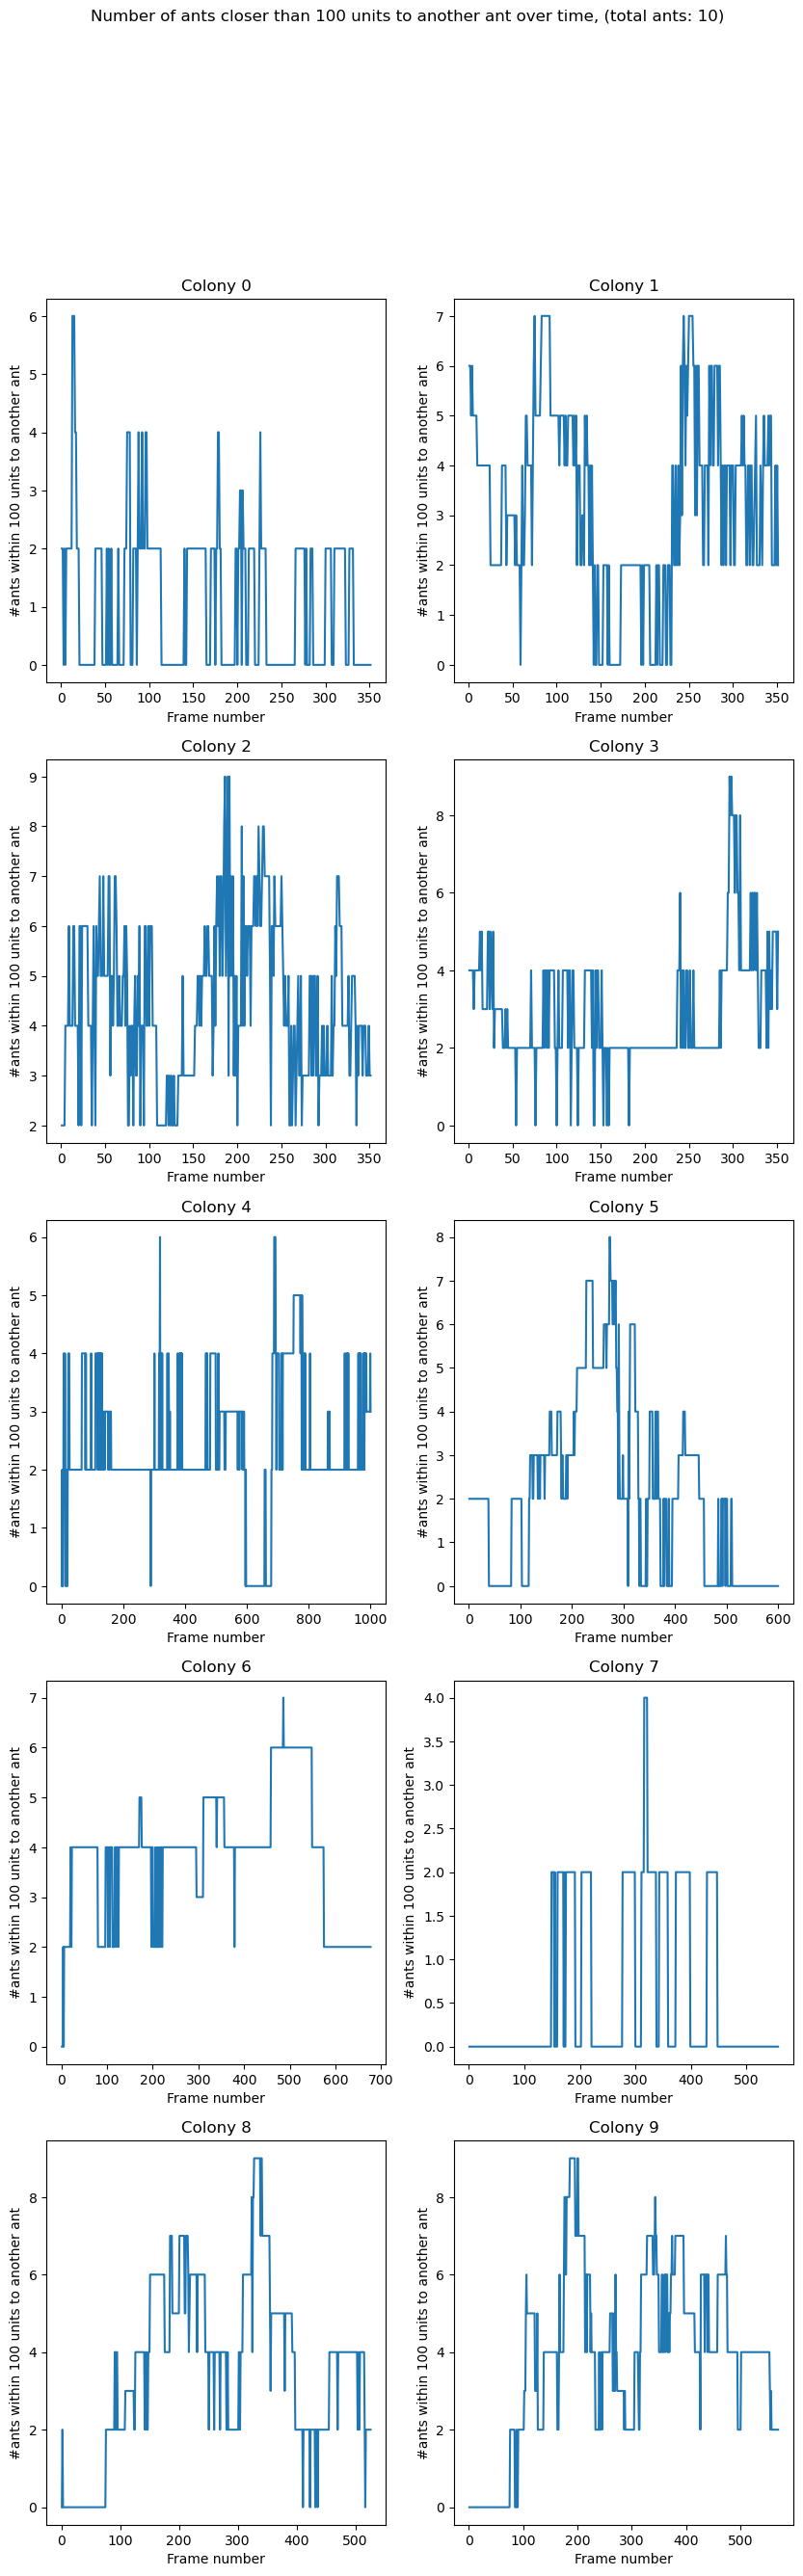

In [63]:
plt.figure(figsize=(10, 30))
for i in range(10):
    exec(f'df = df{i}')
    close_ants_count = df.groupby('frameno').apply(count_close_ants)
    plt.subplot(5, 2, i+1)
    plt.title(f'Colony {i}')
    plt.plot(close_ants_count)
    plt.xlabel('Frame number')
    plt.ylabel('#ants within 100 units to another ant')
plt.suptitle(f'Number of ants closer than 100 units to another ant over time, (total ants: {df['ant_id'].nunique()})')
plt.show()

- fluctuating
- ants might change their behaviour based on observing the number of ants around them
- too much -> go away
- too few -> stay
- lets quantify this effect over all colony
- lets test this by surrogate testing

## Ants outside frame

In [64]:
for i in range(10):
    df = get_nth_colony(i)
    print(f'image size for colony {i}: ({df["x"].min()} - {df["x"].max()}) x ({df["y"].min()} - {df["y"].max()})')

image size for colony 0: (483.225 - 1435.97) x (-47.0 - 855.165)
image size for colony 1: (509.82500000000005 - 1479.5) x (-29.8728 - 939.0)
image size for colony 2: (413.099 - 1257.03) x (35.4169 - 876.928)
image size for colony 3: (642.112 - 1489.17) x (-22.6184 - 910.094)
image size for colony 4: (415.518 - 1428.72) x (-22.6184 - 939.0)
image size for colony 5: (-32.0 - 1070.13) x (-32.0 - 624.0)
image size for colony 6: (-32.0 - 1090.8) x (-32.0 - 624.0)
image size for colony 7: (-32.0 - 1184.0) x (-32.0 - 624.0)
image size for colony 8: (-32.0 - 954.186) x (27.2982 - 624.0)
image size for colony 9: (-32.0 - 1184.0) x (42.221999999999994 - 547.061)


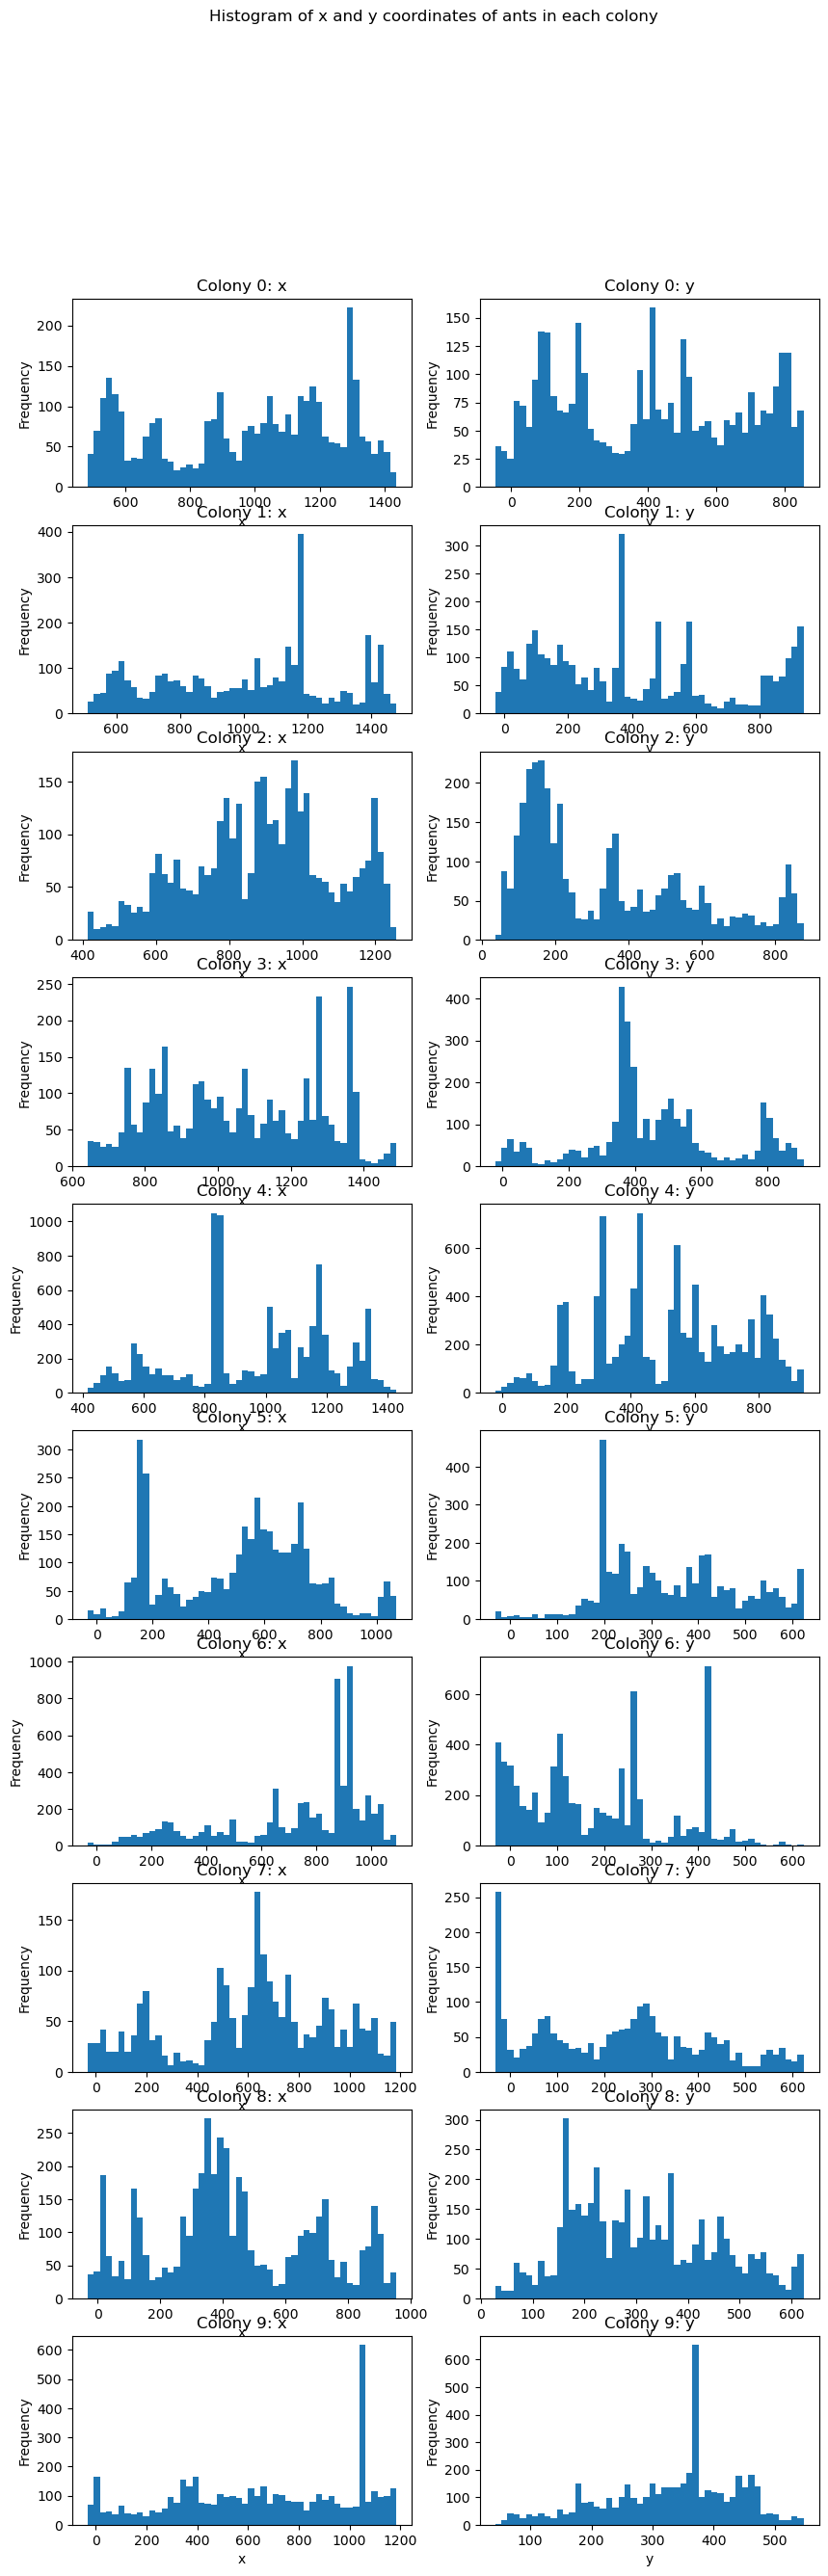

In [65]:
plt.figure(figsize=(10, 30))
for i in range(10):
    exec(f'df = df{i}')
    plt.subplot(10, 2, i*2 + 1)
    plt.title(f'Colony {i}: x')
    plt.hist(df['x'], bins=50)
    plt.xlabel('x')
    plt.ylabel('Frequency')

    plt.subplot(10, 2, i*2 + 2)
    plt.title(f'Colony {i}: y')
    plt.hist(df['y'], bins=50)
    plt.xlabel('y')
    plt.ylabel('Frequency')
    
plt.suptitle('Histogram of x and y coordinates of ants in each colony')
plt.show()

- uniform and gaussian like distributions with local peaks at the sides show ants that left the frame
- noticable at colony 5xy, 6xy, 7xy, 8xy, 9xy - outdoor colonies

## Correlations

data seems random

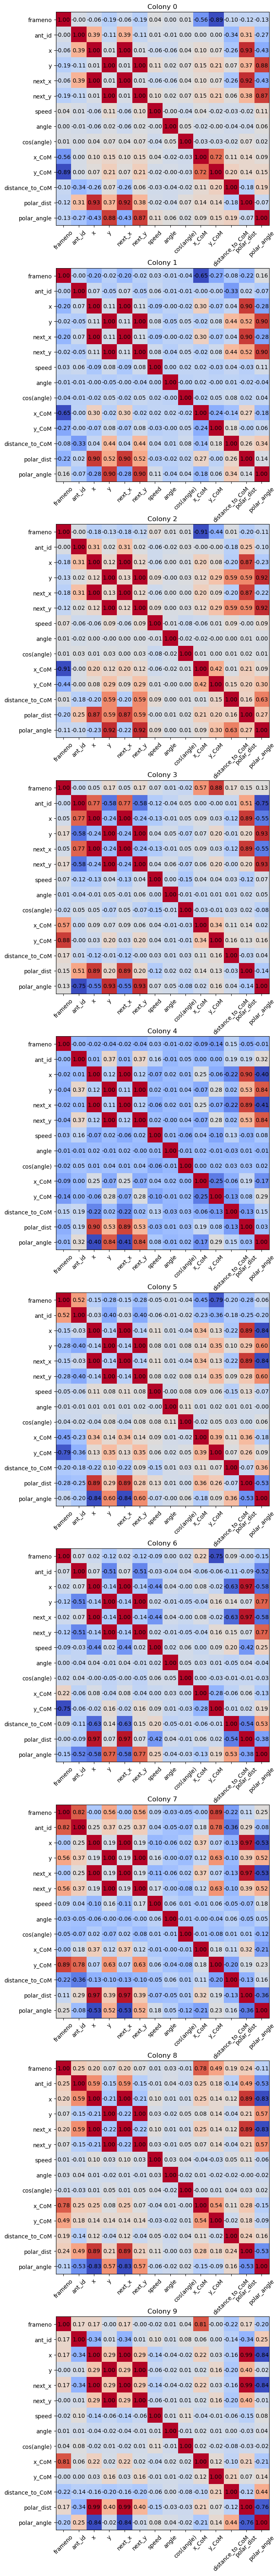

In [66]:
# plot a correlation hetmap

plt.figure(figsize=(15, 80))
for i in range(10):
    exec(f'df = df{i}')
    corr = df.corr()
    plt.subplot(10, 1, i+1)
    plt.title(f'Colony {i}')
    plt.imshow(corr, cmap='coolwarm', interpolation='none')
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
    plt.yticks(range(len(corr.columns)), corr.columns)
    # display correlation values
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            plt.text(i, j, f'{corr.iloc[i, j]:.2f}', ha='center', va='center', color='black')

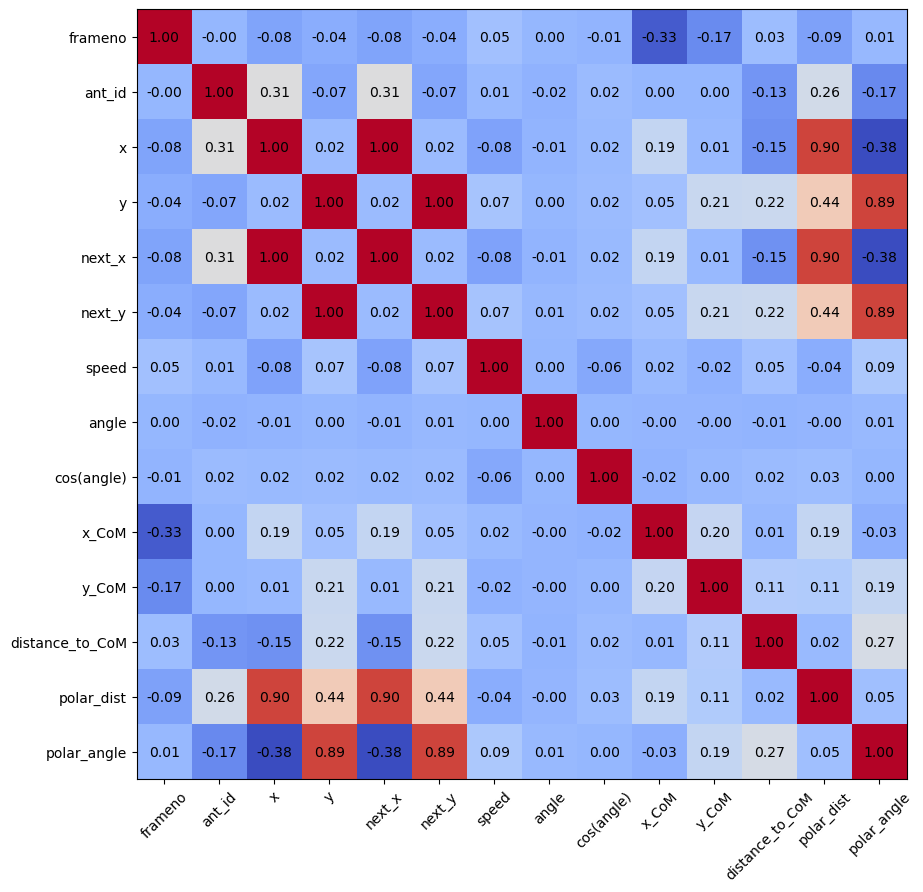

In [67]:
# plot the mean off correlation matrixes for colonies 1 to 5
plt.figure(figsize=(10, 10))
mean_corrs = []
for i in range(5):
    exec(f'df = df{i}')
    mean_corrs.append(df.corr())
mean_corr = sum(mean_corrs) / 5
plt.imshow(mean_corr, cmap='coolwarm', interpolation='none')
plt.xticks(range(len(mean_corr.columns)), mean_corr.columns, rotation=45)
plt.yticks(range(len(mean_corr.columns)), mean_corr.columns)
# display correlation values
for i in range(len(mean_corr.columns)):
    for j in range(len(mean_corr.columns)):
        plt.text(i, j, f'{mean_corr.iloc[i, j]:.2f}', ha='center', va='center', color='black')


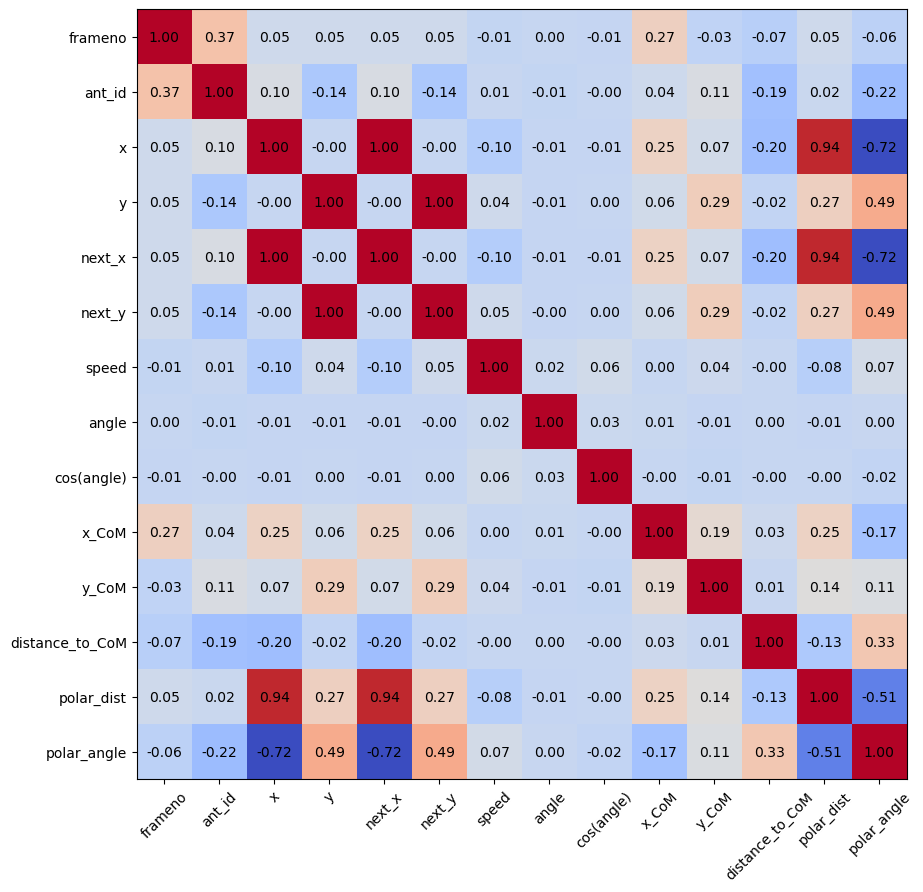

In [68]:
# plot the mean off correlation matrixes for colonies 6 to 10
plt.figure(figsize=(10, 10))
mean_corrs = []
for i in range(5, 10):
    exec(f'df = df{i}')
    mean_corrs.append(df.corr())
mean_corr = sum(mean_corrs) / 5
plt.imshow(mean_corr, cmap='coolwarm', interpolation='none')
plt.xticks(range(len(mean_corr.columns)), mean_corr.columns, rotation=45)
plt.yticks(range(len(mean_corr.columns)), mean_corr.columns)
# display correlation values
for i in range(len(mean_corr.columns)):
    for j in range(len(mean_corr.columns)):
        plt.text(i, j, f'{mean_corr.iloc[i, j]:.2f}', ha='center', va='center', color='black')


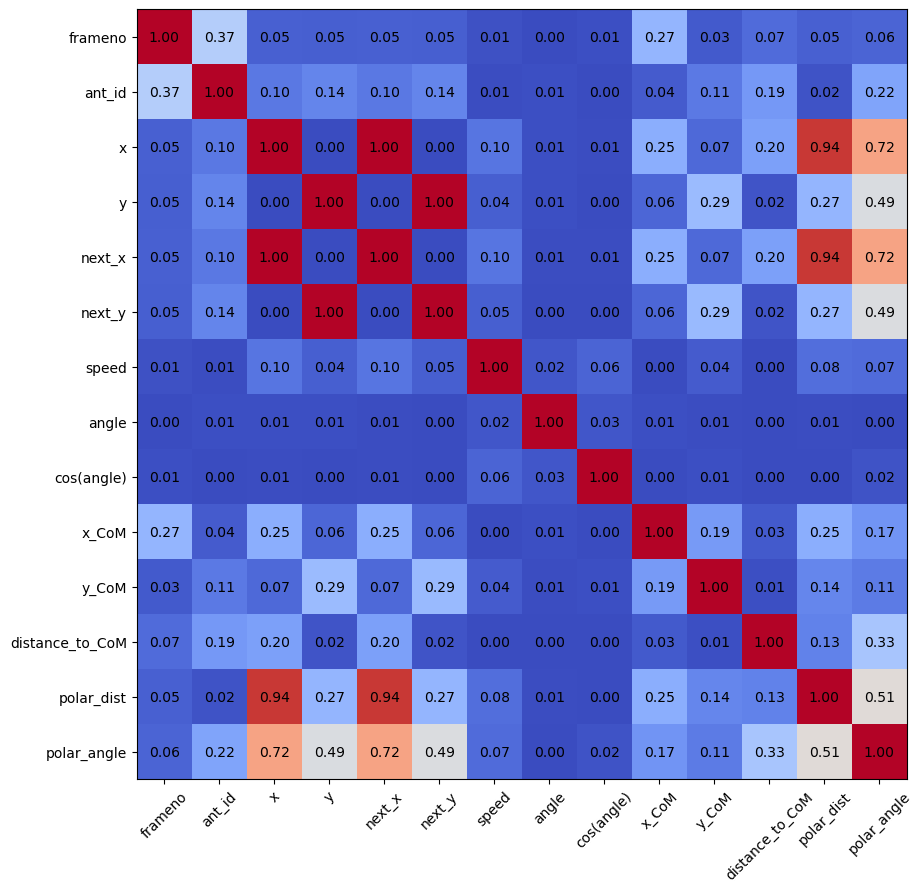

In [69]:
# plot the differences between the mean correlation matrixes of colonies 1 to 5 and 6 to 10
plt.figure(figsize=(10, 10))
mean_corrs1 = []
for i in range(5):
    exec(f'df = df{i}')
    mean_corrs1.append(df.corr())
mean_corr1 = sum(mean_corrs1) / 5
mean_corrs2 = []
for i in range(5, 10):
    exec(f'df = df{i}')
    mean_corrs1.append(df.corr())
mean_corr2 = sum(mean_corrs1) / 5
mean_corr_diff = abs(mean_corr1 - mean_corr2)
plt.imshow(mean_corr_diff, cmap='coolwarm', interpolation='none')
plt.xticks(range(len(mean_corr_diff.columns)), mean_corr_diff.columns, rotation=45)
plt.yticks(range(len(mean_corr_diff.columns)), mean_corr_diff.columns)
# display correlation values
for i in range(len(mean_corr_diff.columns)):
    for j in range(len(mean_corr_diff.columns)):
        plt.text(i, j, f'{mean_corr_diff.iloc[i, j]:.2f}', ha='center', va='center', color='black')

## Hypothesis 1

ants move at random

### Create surrogate data

- generate surrogate data by amplitude adjusted fourier transform - preserving autocorrelation
- start with random points (alternatively sample from distribution of initial positions)
- (alternatively sample trajectories from velocity and angle of observed motion)

In [77]:
# get the mean and standard deviation of speed for an ant
df['ant_id'].unique()

array([ 6, 27, 33, 35, 39, 40, 42, 43, 48, 54])

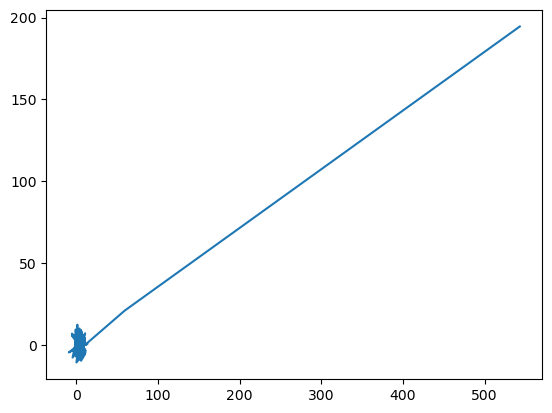

In [86]:
ant_x_mean = df[df['ant_id'] == 6]['x'].mean()
ant_x_std = df[df['ant_id'] == 6]['x'].std()

ant_y_mean = df[df['ant_id'] == 6]['y'].mean()
ant_y_std = df[df['ant_id'] == 6]['y'].std()

ant_speed_mean = df[df['ant_id'] == 6]['speed'].mean()
ant_speed_std = df[df['ant_id'] == 6]['speed'].std() 

ant_angle_mean = df[df['ant_id'] == 6]['angle'].mean()
ant_angle_std = df[df['ant_id'] == 6]['angle'].std()

ant_x_start = np.random.normal(ant_x_mean, ant_x_std, 1)
ant_y_start = np.random.normal(ant_y_mean, ant_y_std, 1)

iterations = len(df[df['ant_id'] == 6])

xs = [ant_x_start]
ys = [ant_y_start]

for i in range(iterations):
    sampled_speed = np.random.normal(ant_speed_mean, ant_speed_std, 1)
    sampled_angle = np.random.normal(ant_angle_mean, ant_angle_std, 1)

    next_x = xs[-1] * 0.1 + sampled_speed * np.cos(sampled_angle) * 0.9
    next_y = ys[-1] * 0.1 + sampled_speed * np.sin(sampled_angle) * 0.9

    xs.append(next_x)
    ys.append(next_y)

plt.plot(xs, ys)





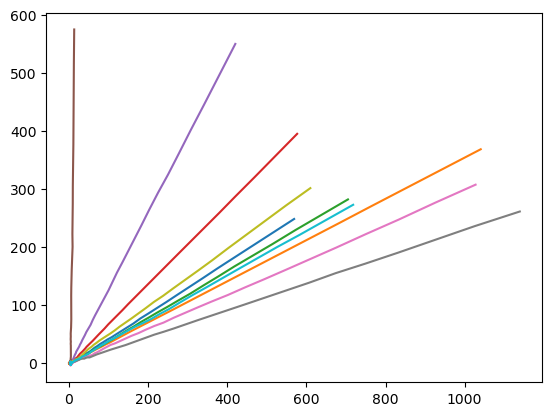

In [98]:
unique_ants = df['ant_id'].unique()

for ant_id in unique_ants:
    ant_x_mean = df[df['ant_id'] == ant_id]['x'].mean()
    ant_x_std = df[df['ant_id'] == ant_id]['x'].std()

    ant_y_mean = df[df['ant_id'] == ant_id]['y'].mean()
    ant_y_std = df[df['ant_id'] == ant_id]['y'].std()

    ant_speed_mean = df[df['ant_id'] == ant_id]['speed'].mean()
    ant_speed_std = df[df['ant_id'] == ant_id]['speed'].std() 

    ant_angle_mean = df[df['ant_id'] == ant_id]['angle'].mean()
    ant_angle_std = df[df['ant_id'] == ant_id]['angle'].std()

    ant_x_start = np.random.normal(ant_x_mean, ant_x_std, 1)
    ant_y_start = np.random.normal(ant_y_mean, ant_y_std, 1)

    iterations = len(df[df['ant_id'] == ant_id])

    xs = [ant_x_start]
    ys = [ant_y_start]

    sampled_speeds = np.random.normal(ant_speed_mean, ant_speed_std, iterations)
    sampled_angles = np.random.normal(ant_angle_mean, ant_angle_std, iterations)

    for i in range(iterations):
        

        next_x = xs[-1] * 0.9 + sampled_speeds[i] * np.cos(sampled_angles[i]) * 0.1
        next_y = ys[-1] * 0.9 + sampled_speeds[i] * np.sin(sampled_angles[i]) * 0.1

        xs.append(next_x)
        ys.append(next_y)

    plt.plot(xs, ys)

plt.show()

In [97]:
sampled_angles

array([ 8.97981307e-01, -9.54842844e-01,  8.62327163e-01,  9.29814606e-01,
       -8.85784020e-01,  1.13616847e+00,  2.36208067e+00, -8.57702905e-01,
       -4.31967551e-01,  5.72999278e-01,  1.29020501e+00,  5.94907217e-01,
       -2.67912419e-01, -8.44253232e-01, -4.63748127e-01, -1.12489367e+00,
       -6.25556007e-01, -9.14070017e-02,  7.22990839e-01, -1.26911517e-01,
        2.09337043e-01,  2.74086070e-01,  8.20989953e-01,  4.64339431e-01,
        1.25444312e+00,  3.69147774e-01,  2.05807888e-02,  1.18328164e+00,
        4.70171181e-01, -3.80524213e-01,  2.39872548e-01,  6.30090850e-01,
        4.23969550e-01, -1.84711749e-01, -4.32337768e-01,  3.89154721e-01,
        2.57949332e-01,  2.63042638e-01,  2.33835470e-01, -3.83714948e-01,
        1.04400519e+00,  3.66291573e-01, -5.34590987e-01,  4.45832610e-01,
        1.06747451e+00,  1.17973750e+00,  3.11977121e-02,  4.80365443e-01,
       -7.65219582e-01,  9.66590391e-02,  2.38930262e-01,  6.91001515e-01,
        1.35939421e-01,  

#### Previous attempts

In [42]:
# get initial positions of ants
# Initialize an empty dataframe
df_init_pos = pd.DataFrame(columns=['ant_id', 'first_appearance_frameno', 'initial_position_x', 'initial_position_y'])

# extract the initial positions of the ants in each colony. 'frameno' = 1, 'x', 'y'
for i in df['ant_id'].unique():  # use unique to avoid repeating the same ant
    # find the minimum frameno for each ant
    min_frame = df.loc[df['ant_id'] == i, 'frameno'].min()
    # find the corresponding x and y coordinates
    x = df.loc[(df['ant_id'] == i) & (df['frameno'] == min_frame), 'x'].values[0]
    y = df.loc[(df['ant_id'] == i) & (df['frameno'] == min_frame), 'y'].values[0]
    # print the ant id and its minimum frameno and its initial position
    print(f'ant_id: {i}, first appearance frameno: {min_frame}, initial position: ({x}, {y})')
    # append to the dataframe with the ant_id, first appearance frameno, and initial position
    df_init_pos.loc[len(df_init_pos)] = {'ant_id': i, 'first_appearance_frameno': min_frame, 'initial_position_x': x, 'initial_position_y': y}

df_init_pos

ant_id: 6, first appearance frameno: 1, initial position: (279.646, 167.458)
ant_id: 27, first appearance frameno: 1, initial position: (1056.36, 364.805)
ant_id: 33, first appearance frameno: 31, initial position: (-32.0, 290.186)
ant_id: 35, first appearance frameno: 46, initial position: (1184.0, 469.271)
ant_id: 39, first appearance frameno: 76, initial position: (1184.0, 496.823)
ant_id: 40, first appearance frameno: 80, initial position: (-32.0, 114.54499999999999)
ant_id: 42, first appearance frameno: 98, initial position: (-30.78251, 289.038)
ant_id: 43, first appearance frameno: 105, initial position: (-32.0, 239.675)
ant_id: 48, first appearance frameno: 147, initial position: (1184.0, 310.85)
ant_id: 54, first appearance frameno: 176, initial position: (-32.0, 225.899)


ant_id  first_appearance_frameno  initial_position_x  initial_position_y
0       6                         1           279.64600             167.458
1      27                         1          1056.36000             364.805
2      33                        31           -32.00000             290.186
3      35                        46          1184.00000             469.271
4      39                        76          1184.00000             496.823
5      40                        80           -32.00000             114.545
6      42                        98           -30.78251             289.038
7      43                       105           -32.00000             239.675
8      48                       147          1184.00000             310.850
9      54                       176           -32.00000             225.899

In [43]:
# get the last appearance of each
df_last_pos = pd.DataFrame(columns=['ant_id', 'last_appearance_frameno', 'last_position_x', 'last_position_y'])
for i in df['ant_id'].unique():
    max_frame = df.loc[df['ant_id'] == i, 'frameno'].max()
    x = df.loc[(df['ant_id'] == i) & (df['frameno'] == max_frame), 'x'].values[0]
    y = df.loc[(df['ant_id'] == i) & (df['frameno'] == max_frame), 'y'].values[0]
    print(f'ant_id: {i}, last appearance frameno: {max_frame}, last position: ({x}, {y})')
    df_last_pos.loc[len(df_last_pos)] = {'ant_id': i, 'last_appearance_frameno': max_frame, 'last_position_x': x, 'last_position_y': y}
df_last_pos


ant_id: 6, last appearance frameno: 557, last position: (1184.0, 167.352)
ant_id: 27, last appearance frameno: 569, last position: (1046.02, 364.805)
ant_id: 33, last appearance frameno: 449, last position: (1184.0, 82.401)
ant_id: 35, last appearance frameno: 569, last position: (36.94840000000001, 284.446)
ant_id: 39, last appearance frameno: 490, last position: (-32.0, 244.267)
ant_id: 40, last appearance frameno: 569, last position: (1013.8800000000001, 336.105)
ant_id: 42, last appearance frameno: 569, last position: (1184.0, 297.074)
ant_id: 43, last appearance frameno: 507, last position: (1184.0, 329.217)
ant_id: 48, last appearance frameno: 569, last position: (342.312, 338.401)
ant_id: 54, last appearance frameno: 569, last position: (974.85, 469.271)


ant_id  last_appearance_frameno  last_position_x  last_position_y
0       6                      557        1184.0000          167.352
1      27                      569        1046.0200          364.805
2      33                      449        1184.0000           82.401
3      35                      569          36.9484          284.446
4      39                      490         -32.0000          244.267
5      40                      569        1013.8800          336.105
6      42                      569        1184.0000          297.074
7      43                      507        1184.0000          329.217
8      48                      569         342.3120          338.401
9      54                      569         974.8500          469.271

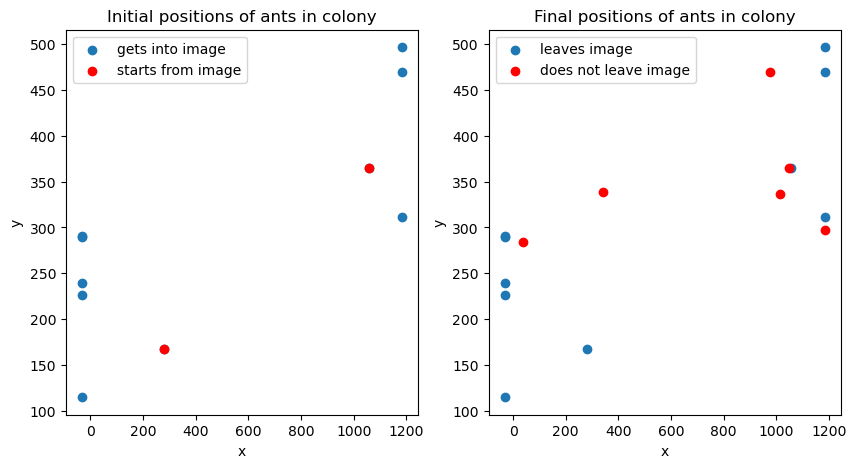

In [44]:
# plot the initial positions of the ants from df_init_pos, just for that colony
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(df_init_pos['initial_position_x'], df_init_pos['initial_position_y'])
plt.scatter(df.loc[df['frameno'] == 1, 'x'], df.loc[df['frameno'] == 1, 'y'], color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['gets into image', 'starts from image'])

plt.title('Initial positions of ants in colony')
plt.subplot(1, 2, 2)
# where frameno = 569 paint red
plt.scatter(df_init_pos['initial_position_x'], df_init_pos['initial_position_y'])
plt.scatter(df.loc[df['frameno'] == 569, 'x'], df.loc[df['frameno'] == 569, 'y'], color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(['leaves image', 'does not leave image'])
plt.title('Final positions of ants in colony')
plt.show()

In [45]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from numpy.fft import fft, ifft

def aaft(data):
    # Transform the data into ranks and create sorted Gaussian noise
    ranks = rankdata(data, method='ordinal')
    random_data = np.random.normal(size=len(data))
    random_sorted = np.sort(random_data)

    # Initialize the surrogate with Gaussian data according to original data ranks
    surrogate = random_sorted[np.argsort(np.argsort(ranks))]

    # Apply Fourier transform
    fourier_transform = fft(surrogate)
    random_phases = np.exp(2j * np.pi * np.random.random(size=len(data)))

    # Adjust Fourier components by random phases and inverse Fourier transform
    adjusted_fourier = fourier_transform * random_phases
    new_surrogate = ifft(adjusted_fourier).real

    # Match the sorted surrogate to the original data's sorting
    final_surrogate = np.empty_like(data)
    final_surrogate[np.argsort(data)] = np.sort(new_surrogate)

    return final_surrogate

# Create a DataFrame to store surrogate data
surrogate_data = pd.DataFrame(columns=['ant_id', 'surrogate_x', 'surrogate_y'])

# Apply AAFT for each ant's 'x' and 'y' data
for ant_id in df['ant_id'].unique():
    ant_data = df[df['ant_id'] == ant_id]
    surrogate_x = aaft(ant_data['x'].values)
    surrogate_y = aaft(ant_data['y'].values)
    surrogate_data.loc[len(surrogate_data)] = {'ant_id': ant_id, 'surrogate_x': surrogate_x, 'surrogate_y': surrogate_y}

# Optionally, save or display the surrogate data
print(surrogate_data.head())
# surrogate_data.to_csv('surrogate_ant_data.csv', index=False)


   ant_id                                        surrogate_x  \
0       6  [-2.297204128650029, -2.0598344724090474, -2.0...   
1      27  [2.0407741320029094, 1.679919842801967, 0.5511...   
2      33  [-2.1459674297488203, -2.145844277167041, -2.1...   
3      35  [1.8317632817698493, 1.7698783595975283, 1.739...   
4      39  [1.4550805769780815, 1.2502332555312805, 1.210...   

                                         surrogate_y  
0  [-0.33689610004414927, -0.333537224656463, -0....  
1  [-0.9590925645574772, -0.9401075938773886, -0....  
2  [-0.0573025730765912, -0.05816637071646539, -0...  
3  [0.466367984153091, 0.5757959734944287, 0.5311...  
4  [0.7754032718335649, 0.7654760621696168, 0.760...  


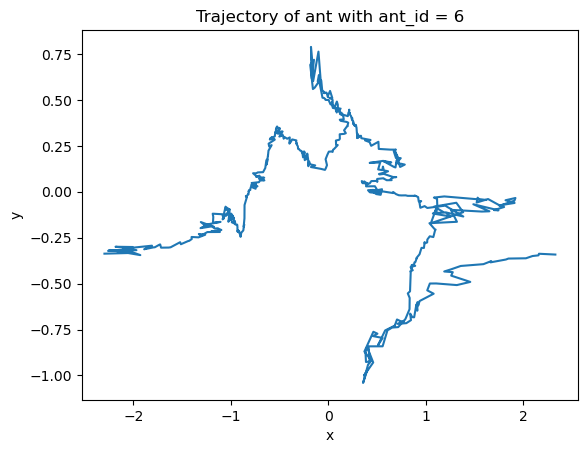

In [46]:
# plot the trajectory of ant with ant_id = 6. the trajectory coordinates are in 'surrogate_x' and 'surrogate_y'
ant_id = 6
# convert array to pandas series
ant_surrogate_x = pd.Series(surrogate_data.loc[surrogate_data['ant_id'] == ant_id, 'surrogate_x'].values[0])
ant_surrogate_y = pd.Series(surrogate_data.loc[surrogate_data['ant_id'] == ant_id, 'surrogate_y'].values[0])
# plot the trajectory
plt.plot(ant_surrogate_x, ant_surrogate_y)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Trajectory of ant with ant_id = {ant_id}')
plt.show()


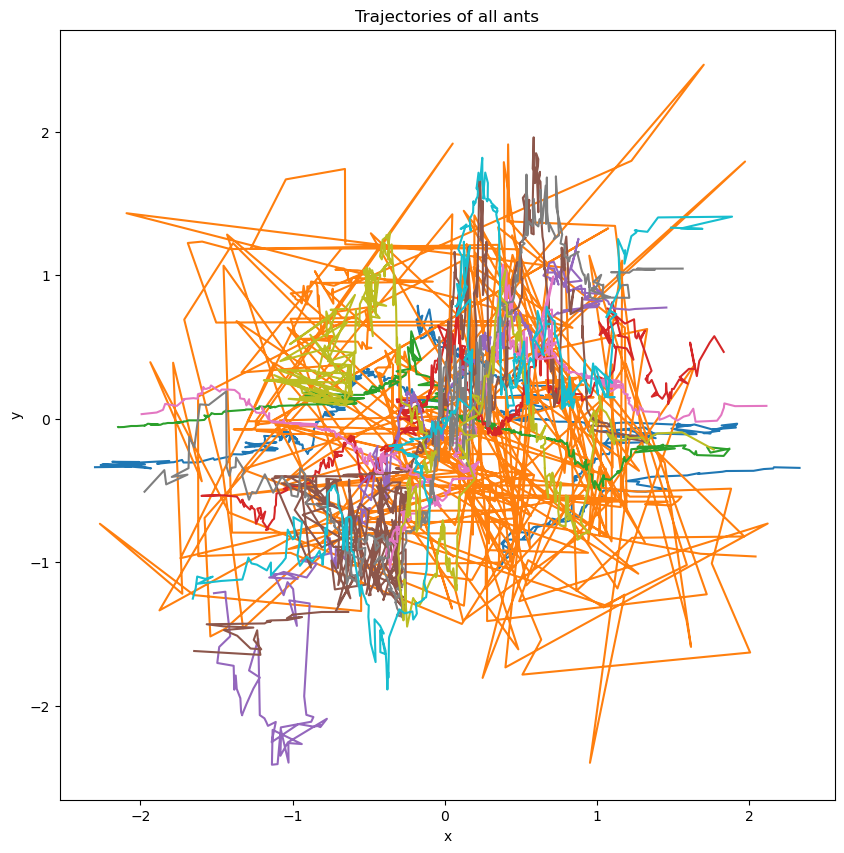

In [47]:
# plot all ants trajectories in one plot with different colours
plt.figure(figsize=(10, 10))
for ant_id in df['ant_id'].unique():
    ant_surrogate_x = pd.Series(surrogate_data.loc[surrogate_data['ant_id'] == ant_id, 'surrogate_x'].values[0])
    ant_surrogate_y = pd.Series(surrogate_data.loc[surrogate_data['ant_id'] == ant_id, 'surrogate_y'].values[0])
    plt.plot(ant_surrogate_x, ant_surrogate_y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of all ants')
plt.show()

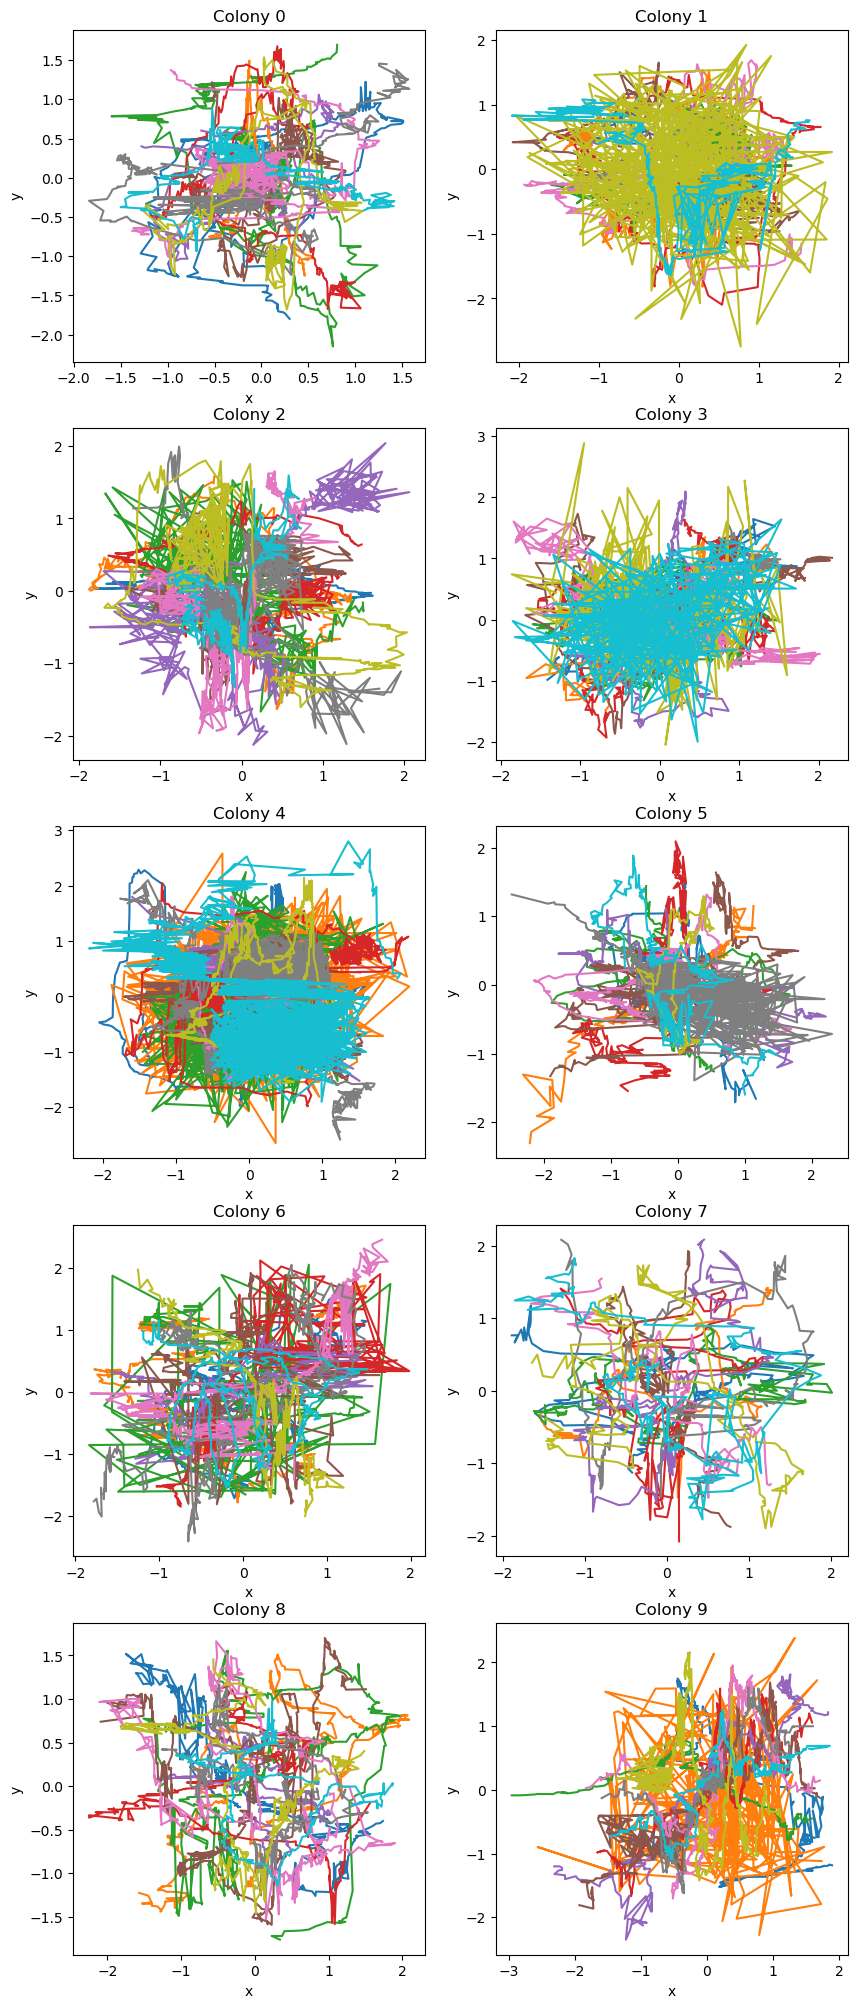

In [54]:
# plot all ants trajectories in one plot with different colours
plt.figure(figsize=(10, 25))
for i in range(10):
    exec(f'df = df{i}')
    plt.subplot(5, 2, i+1)

    surrogate_data = pd.DataFrame(columns=['ant_id', 'surrogate_x', 'surrogate_y'])

    # Apply AAFT for each ant's 'x' and 'y' data
    for ant_id in df['ant_id'].unique():
        ant_data = df[df['ant_id'] == ant_id]
        surrogate_x = aaft(ant_data['x'].values)
        surrogate_y = aaft(ant_data['y'].values)
        surrogate_data.loc[len(surrogate_data)] = {'ant_id': ant_id, 'surrogate_x': surrogate_x, 'surrogate_y': surrogate_y}

    for ant_id in df['ant_id'].unique():
        ant_surrogate_x = pd.Series(surrogate_data.loc[surrogate_data['ant_id'] == ant_id, 'surrogate_x'].values[0])
        ant_surrogate_y = pd.Series(surrogate_data.loc[surrogate_data['ant_id'] == ant_id, 'surrogate_y'].values[0])
        plt.plot(ant_surrogate_x, ant_surrogate_y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Colony {i}')
plt.show()

In [100]:
# 0, 7, 8 is good for surrogate testing

# save the surrogate x y coordinates for colonies 0, 7, 8
for i in [0, 7, 8]:
    exec(f'df = df{i}')
    surrogate_data = pd.DataFrame(columns=['ant_id', 'surrogate_x', 'surrogate_y'])

    # Apply AAFT for each ant's 'x' and 'y' data
    for ant_id in df['ant_id'].unique():
        ant_data = df[df['ant_id'] == ant_id]
        surrogate_x = aaft(ant_data['x'].values)
        surrogate_y = aaft(ant_data['y'].values)
        surrogate_data.loc[len(surrogate_data)] = {'ant_id': ant_id, 'surrogate_x': surrogate_x, 'surrogate_y': surrogate_y}

    surrogate_data.to_csv(f'surrogate_data_colony_{i}.csv', index=False)
    

# surrogate testing for Daniel and Barto
# write up methodology
# check travis's structure


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from numpy.fft import fft, ifft

def aaft(data):
    # Transform the data into ranks and create sorted Gaussian noise
    ranks = rankdata(data, method='ordinal')
    random_data = np.random.normal(size=len(data))
    random_sorted = np.sort(random_data)

    # Initialize the surrogate with Gaussian data according to original data ranks
    surrogate = random_sorted[np.argsort(np.argsort(ranks))]

    # Apply Fourier transform
    fourier_transform = fft(surrogate)
    random_phases = np.exp(2j * np.pi * np.random.random(size=len(data)))

    # Adjust Fourier components by random phases and inverse Fourier transform
    adjusted_fourier = fourier_transform * random_phases
    new_surrogate = ifft(adjusted_fourier).real

    # Match the sorted surrogate to the original data's sorting
    final_surrogate = np.empty_like(data)
    final_surrogate[np.argsort(data)] = np.sort(new_surrogate)

    return final_surrogate

# Create a DataFrame to store surrogate data
surrogate_data = pd.DataFrame(columns=['ant_id', 'surrogate_speed', 'surrogate_angle'])

# Apply AAFT for each ant's 'x' and 'y' data
for ant_id in df['ant_id'].unique():
    ant_data = df[df['ant_id'] == ant_id]
    surrogate_speed = aaft(ant_data['speed'].values)
    surrogate_angle = aaft(ant_data['angle'].values)
    surrogate_data.loc[len(surrogate_data)] = {'ant_id': ant_id, 'surrogate_speed': surrogate_speed, 'surrogate_angle': surrogate_angle}

# Optionally, save or display the surrogate data
surrogate_data.head()
# surrogate_data.to_csv('surrogate_ant_data.csv', index=False)

ant_id                                    surrogate_speed  \
0       6  [-0.5476842449674181, -1.0490133986529506, -0....   
1      27  [0.1655578949641617, 0.6381755373892458, 0.253...   
2      33  [-1.5123836718422616, -0.674708679114088, -0.3...   
3      35  [-0.4907111328077798, -0.8073835011227605, -0....   
4      39  [-0.950612855373137, -1.5402196677184437, -1.2...   

                                     surrogate_angle  
0  [-0.1021468504185027, 0.008571083600733567, -0...  
1  [-0.3629184579566544, -0.7047092709104944, -1....  
2  [-2.2604777337388784, 1.1868042195130974, 1.23...  
3  [0.6466532809211176, -0.8522371515364273, -0.8...  
4  [-2.357194533608166, -1.6556288259404388, 1.24...

In [ ]:
# clear variable ant_id
del ant_id

In [ ]:
# create new column in the surrogate_data dataframe to store the surrogate positions
surrogate_data['surrogate_positions'] = None
surrogate_positions_x = []
surrogate_positions_y = []

for ant_id in df['ant_id'].unique():

    ant_surrogate_positions_x = []
    ant_surrogate_positions_y = []
    # generate a random starting point for the ant
    x = np.random.uniform(df['x'].min(), df['x'].max())
    y = np.random.uniform(df['y'].min(), df['y'].max())
    # generate next positions based on the surrogate data, starting from the random point with surrogate_speed and surrogate_angle
    ant_surrogate_speed = surrogate_data.loc[surrogate_data['ant_id'] == ant_id, 'surrogate_speed']
    ant_surrogate_angle = surrogate_data.loc[surrogate_data['ant_id'] == ant_id, 'surrogate_angle']
    for i in range(len(ant_surrogate_speed)):
        # calculate the next position based on the speed and angle
        x += 50* ant_surrogate_speed.iloc[i] * np.cos(ant_surrogate_angle.iloc[i])
        y += 50 * ant_surrogate_speed.iloc[i] * np.sin(ant_surrogate_angle.iloc[i])
        # append the new position to the dataframe
        ant_surrogate_positions_x.append(x)
        ant_surrogate_positions_y.append(y)
    
    # add the surrogate positions to the series surrogate_positions
    surrogate_positions_x.extend(ant_surrogate_positions_x)
    surrogate_positions_y.extend(ant_surrogate_positions_y)



# Function to sort based on deviation from median
def sort_by_deviation_from_median(data):
    median_value = pd.Series(data).median()
    # Calculate deviations from the median and sort by this deviation
    sorted_data = sorted(data, key=lambda x: abs(x - median_value))
    return sorted_data

# Sort the data using the defined function
sorted_positions_x = sort_by_deviation_from_median(surrogate_positions_x)
sorted_positions_y = sort_by_deviation_from_median(surrogate_positions_y)

# Convert sorted lists to Series and add them to the DataFrame
surrogate_data['surrogate_positions_x'] = pd.Series(sorted_positions_x)
surrogate_data['surrogate_positions_y'] = pd.Series(sorted_positions_y)

'''
# convert the lists to series and add them to the surrogate_data dataframe
surrogate_data['surrogate_positions_x'] = pd.Series(surrogate_positions_x)
surrogate_data['surrogate_positions_y'] = pd.Series(surrogate_positions_y)
'''

TypeError: Cannot convert [array([ 75.68413382,  50.47686376,  75.55795727,  77.61437114,
        117.31363323, 139.80482048, 113.00109184, 143.98792238,
        109.78831552,  79.64267309,  88.23863013,  51.71278206,
         99.05238245, 167.10756676, 128.88430401, 129.63652451,
         79.78104561, 110.06226766, 124.84857567, 125.59748044,
         88.86966486,  96.20605805, 122.83790661,  99.04547297,
        133.64912353,  65.85972272,  98.94059655,  87.15300758,
        125.96817471, 128.99713569,  65.13725169,  88.80171077,
        118.97434097,  66.13686812,  65.10385481, 101.84757652,
         80.76768743,  82.06197033,  84.46821038,  80.99953684,
         63.54225396,  99.38427153,  88.55165659,  51.79432694,
         64.10122233,  81.69931188,  66.89194423,  86.11765157,
         47.06444611,  93.89805751,  80.8265542 ,  66.328386  ,
         89.33810481,  92.38619005,  88.70528268, 138.69244155,
        109.8218253 ,  75.64584408,  67.94946708,  75.67185812,
         77.5674024 ,  77.25967238, 112.35241242,  90.92458589,
         99.42753562,  94.03596467, 109.33748783,  89.90951741,
        126.84869697, 128.84690189,  81.36985514, 115.89639609,
         99.36963339, 103.92380411,  90.01700546,  50.32752437,
         96.3738325 ,  88.8810875 , 155.76199645,  88.98585618,
         91.35549582, 134.8008077 , 139.48649395,  94.56897561,
        128.74866033, 112.80442848, 145.23412636, 125.71095651,
         75.36077339, 113.59614193, 174.41380331, 153.02320125,
        126.36354909, 161.12317237, 143.5670767 ,  66.49251979,
        117.70875961, 156.10686469, 145.66267095,  88.37507071,
         87.33669343, 146.00427457, 134.4222704 , 132.59072652,
        103.87819161, 108.15507886, 126.37302183, 165.0600565 ,
        117.55417745,  81.54692619, 152.52922849,  63.69705149,
        107.77843892, 103.22951392,  66.57571592, 128.67309233,
        117.74857823,  78.45131994, 134.38852836, 110.36704748,
        113.22256959,  66.6087869 ,  98.94615141, 103.81400593,
         81.3090404 ,  90.39162275,  80.86346007, 108.02115154,
        102.1993396 ,  64.56300722, 132.13387877,  75.80855753,
         98.23743414, 110.74256381, 157.81639295, 117.34248879,
         79.40350064,  98.6076105 , 140.59809004, 110.19249828,
        128.82528239,  98.69078783, 160.46627146,  89.79350335,
        117.90439066, 130.19141548,  64.43909109,  68.99301131,
         98.7894573 ,  52.13962959,  80.19748444, 102.44349997,
        122.25229367,  89.66176718, 117.23907192,  89.2540828 ,
         98.87081129, 117.43177913, 137.11745859,  64.07443974,
         64.78784494,  98.49585011,  65.48379885,  79.03433543,
        143.68786217,  75.47062987,  98.91988073,  81.11726036,
         78.88644924, 112.1540724 ,  80.57108655,  87.42065145,
        160.737256  , 125.07242096, 154.48538407, 103.15169635,
         99.60915623, 145.17446614, 128.44563202,  66.59791115,
        155.19424881, 129.48101699, 103.29437207,  79.58061686,
        137.79422331,  88.18856722,  96.87762358, 142.71045788,
        123.04849837,  79.39558057,  90.1494192 , 118.4587725 ,
        120.02793029, 102.88938581, 116.75310031, 139.45432631,
        124.47677108, 145.3569552 , 105.64384772, 150.05290147,
         68.30365461, 120.85766276,  99.14039417, 123.55271189,
        153.88304379, 135.15779531, 109.63015704, 132.76137828,
        123.35597687, 138.45221419, 125.23211326, 112.53505787,
        142.66580819, 134.38413625,  80.71609245,  80.22919048,
        113.92002487,  88.49005102, 125.2505827 ,  75.31332791,
        113.1507616 , 140.60686395, 102.65546906, 135.20981699,
         64.62497582, 112.61503462, 103.40598434,  86.12257055,
        113.15941596,  94.43336187,  81.52245848, 118.03341268,
        124.24815813, 124.16227405,  99.38234063, 126.9807063 ,
         68.60389681, 129.01758282, 128.85866328,  96.00909243,
        117.61043661,  66.99387646, 137.29890016, 118.30223422,
        115.53860828,  46.28739242, 134.5722569 ,  50.12922216,
         90.0110816 , 124.25155443,  98.46979315, 123.18529109,
        107.83448686,  98.70460685, 130.94578157,  78.31650168,
         74.20536565, 106.70890547,  80.90114839, 113.10922563,
         68.91971385, 129.75830652,  99.50465934,  67.74688735,
         88.78558976,  97.53145612,  69.16769777, 124.68786547,
        129.75731024, 119.19404848,  88.75609246,  77.4151969 ,
        112.76362575, 129.0395948 ,  72.09562047,  93.9479024 ,
        141.61131192,  98.22766367, 117.22942226,  74.83797402,
         88.26003935, 116.86558457,  89.09773745,  50.72532224,
         92.6023009 , 136.60690715,  78.31744611,  88.75666108,
         67.15028481, 117.70264147, 124.25575151, 129.3066423 ,
        152.42159956, 116.92567582, 132.92679981,  63.85697009,
         99.25209779,  68.68140909,  98.67638108, 117.42697488,
         64.71587002, 127.43806689,  72.83006094, 126.06923078,
         81.1916253 , 146.02619593,  98.39858441, 128.17520596,
        106.88564246, 118.56010787,  75.57893663, 159.7813876 ,
        159.46077004,  89.0556138 , 138.56205824, 142.42572638,
        111.39754162, 138.48326861, 115.79007693, 113.7170279 ,
        116.46653123, 104.03989707, 123.77029211, 151.96024995,
        131.65888485, 117.36351139,  83.37641852, 101.19127622,
        116.53628717,  92.79437972,  86.41375371,  98.03853383,
        138.90853582, 106.57092804, 106.46233594, 164.15512877,
         92.28243032, 100.2963904 , 113.46641821, 123.00462537,
        124.70066352, 123.66643306, 101.3091237 ,  95.46424458,
        117.23183447, 144.91504228,  78.56690663, 101.21330486,
         63.66183346,  84.35266866,  76.98661214, 150.4351212 ,
         86.24238445,  99.88505834,  86.01148641, 128.4101568 ,
         61.98985571, 128.51936903,  77.79902857,  33.62061834,
         84.1441899 , 138.04834909,  93.61271249, 113.0274105 ,
         78.59396648,  97.46647331,  97.34184931, 111.97333337,
        127.47455124, 131.70700472,  93.24395382,  76.87862709,
        141.65836792,  99.94711059,  92.52821109, 121.45277938,
         84.75042631,  78.07127878, 110.88257564,  62.25372295,
         99.77148183, 121.15984588,  91.32455652,  87.59861504,
        110.01742691,  76.82468635, 123.65274131, 107.29392836,
         91.89149629, 112.19353152,  93.31189405, 144.75459074,
         85.90161574, 111.4203196 , 118.03656092, 114.61178472,
        131.47008775, 100.75877307,  89.95865082,  78.79703581,
         76.65721684,  77.09024615,  97.30817649,  87.89639229,
        119.06665632, 133.39496793,  76.73458191, 152.44756673,
         86.19504103, 105.37914328, 106.41618435,  45.2006526 ,
         61.33563695,  87.48848521, 169.9874639 ,  97.49997702,
        113.25206973, 164.99650674,  87.99762221, 106.57477008,
         89.27487185, 104.11354114,  91.32316722,  92.20944769,
        133.88416599, 104.11416547,  78.68134407,  92.35094555,
        114.73171198,  60.96325309,  61.42514331, 128.08444837,
        148.78791047,  86.19740331, 112.19204829,  86.33755566,
         45.11927203,  87.21369403, 104.07854081,  72.90034063,
         85.3674542 , 136.2495755 ,  64.87161266,  93.06221805,
        103.98793236, 114.88736629, 128.01533897,  76.70484502,
         78.57777014,  76.95727206,  85.94674137,  98.59172798,
         62.06700745,  71.60942079,  86.90283986, 159.24385469,
        144.04062694, 131.97699836,  88.98807084, 110.11411101,
        142.96363535, 128.38136385,  78.8135509 ,  85.86648708,
        130.00812253,  73.04615111, 111.85025686, 122.84166507,
         85.23344571,  97.16295192, 132.68409328,  32.70254834,
        131.9989247 , 104.83567068, 158.37911659, 100.32261909,
         86.88831853,  85.92639226,  87.23261697,  86.11932398,
        101.15214293,  92.60193283, 120.33372692,  64.5322451 ,
         44.78712518,  87.44619897,  89.39103854,  97.54480082,
        132.56048858,  61.1135728 , 107.47951699,  89.53919499,
         80.13460831, 106.82822975,  87.18222677,  78.36486264,
        139.11682375,  79.99775266, 129.18050437, 124.29971033,
         80.25900156,  89.50869256,  64.61168458,  72.96085538,
        139.20242669, 119.32948191, 110.32563594,  88.35181885,
         77.96299314,  60.78772754, 104.42413989, 140.8001606 ,
         75.36600098,  75.15952102, 100.15536433,  60.24474666,
        107.34869498, 132.88086686, 129.47784458,  60.84133534,
         42.99874934, 137.93810291, 123.19130875,  87.23637131,
        112.17545421, 136.77380279, 105.18212009, 122.92971402,
         62.03204682, 116.77553727, 114.1797946 ,  85.94274455,
         62.01843049, 115.66238168, 174.90929119, 125.38958803,
         78.12524897,  75.1792088 , 112.14755656,  85.48182995,
         78.34698159,  74.31491135,  87.74127482,  97.38223342,
         87.06204524, 127.62904907, 158.6796075 , 101.23456943,
        117.58253688,  87.04524384,  99.5774925 ,  94.90537795,
         86.30538196,  97.62836462,  86.21968589,  96.1258015 ,
         81.29286101])
 array([531.806226  , 548.37561779, 520.78239738, 530.00828423,
        521.87044728, 523.70350681, 521.22143503, 527.30420918,
        521.16435805, 534.04886103, 531.8711041 , 541.52723667,
        538.71758611, 521.2854983 , 516.95506893, 562.4834942 ,
        523.8253583 , 569.08812571, 529.24145147, 536.5576951 ,
        549.40603184, 551.83215422, 514.77548435, 522.33079069,
        527.8053304 , 529.19376082, 529.15745785, 523.24925841,
        523.16440818, 523.09830765, 523.08499406, 523.03979562,
        523.69062619, 522.92337884, 522.77682186, 522.61123436,
        522.53949373, 522.51484881, 522.42705023, 522.38322053,
        522.37446404, 522.32135851, 541.45352833, 559.88998237,
        553.562448  , 532.69545583, 575.52742253, 566.06432546,
        529.22793668, 531.25913794, 575.31920304, 579.76829529,
        517.24637155, 517.33346249, 517.22322578, 517.22141036,
        517.61814976, 517.51319405, 535.26931717, 550.30248189,
        514.0345853 , 534.88120845, 534.70997584, 516.60418904,
        545.01061583, 554.39584011, 544.44290405, 540.29479841,
        555.98749116, 533.95399891, 531.66469809, 535.03403729,
        529.20005154, 526.56430153, 545.82993241, 528.88504494,
        531.7004603 , 537.41138998, 539.94140718, 525.12185782,
        546.03163378, 545.44225882, 522.9452407 , 538.52528225,
        520.75991756, 538.15466863, 523.22157871, 517.24505553,
        562.1566415 , 520.57204212, 535.96048034, 536.52789184,
        558.6255472 , 543.80316085, 543.72959877, 539.34398951,
        549.2853881 , 519.78127483, 516.74115747, 526.85029432,
        544.95352029, 529.46726142, 531.6564368 , 534.45594406,
        532.64784386, 539.79383736, 532.19961545, 533.32505677,
        556.88294919, 531.62263979, 525.81762518, 517.36837644,
        541.08201053, 534.38940107, 543.9289681 , 531.60390635,
        545.55715178, 519.34232663, 531.98314922, 523.75274234,
        561.47404976, 537.03190088, 550.91932051, 563.30037419,
        567.49126017, 565.17049944, 535.92001228, 535.30767707,
        536.06548278, 521.19117841, 531.49586557, 514.32900939,
        550.63920546, 546.93802049, 516.67189739, 560.13521655,
        529.10046106, 548.14188998, 520.9728825 , 537.85857838,
        521.62358025, 517.823806  , 522.03475136, 516.38237231,
        539.79245086, 539.4477853 , 529.33394906, 533.42772024,
        532.17065341, 528.46834949, 526.26334569, 526.15343002,
        526.14893584, 526.15247494, 526.03613234, 526.03520721,
        525.9335069 , 525.8857788 , 525.88942847, 525.77484355,
        525.76911445, 525.69724989, 525.64896214, 525.63284626,
        525.63560198, 516.15005226, 518.4729594 , 516.47569327,
        500.7439647 , 497.88655178, 515.15262715, 496.14079265,
        496.05227538, 496.00640721, 495.92362213, 495.89631175,
        495.53200018, 495.2321223 , 520.43728338, 531.09919603,
        495.44035074, 495.01550106, 528.48048666, 528.3370646 ,
        493.83718458, 493.77600226, 493.6001189 , 493.5106737 ,
        496.23317001, 496.31813124, 499.06042638, 496.75876634,
        499.13464143, 499.31703431, 499.2264715 , 499.20103971,
        518.86114481, 511.99446763, 542.95351437, 516.73451227,
        532.09315326, 558.71272556, 559.29257901, 550.3248501 ,
        534.82234396, 567.77190819, 574.00829595, 567.966767  ,
        498.68262032, 528.17284669, 544.7077985 , 523.37330688,
        525.94678691, 526.81025324, 540.91548903, 549.7148084 ,
        524.2993544 , 532.93698986, 544.25477336, 555.08674799,
        539.56219145, 528.72122265, 539.68315347, 532.04411303,
        516.37836655, 541.67033274, 546.59484215, 540.3888587 ,
        517.86145361, 533.53642468, 539.82452419, 543.51957945,
        530.80372943, 568.06262103, 544.76308022, 527.8660726 ,
        532.29715976, 526.1565339 , 551.74175292, 532.52927104,
        524.75333885, 534.62884498, 546.11287139, 526.0624982 ,
        530.4737137 , 532.88255432, 539.18613147, 525.8090064 ,
        521.96814975, 581.09150272, 581.29975394, 531.76054997,
        554.69809979, 546.22581445, 532.69114145, 538.75479967,
        530.43868881, 534.75237323, 542.24986078, 532.52982211,
        514.49943551, 539.91718248, 533.67359547, 522.8852456 ,
        531.87741685, 519.90182077, 533.98943852, 533.56247889,
        544.06072097, 539.83112618, 541.83422165, 509.46237196,
        509.41154754, 509.23687172, 508.65584642, 508.60978864,
        508.38339854, 511.97402024, 512.09595071, 515.15228568,
        512.08335273, 515.05291413, 514.88414918, 514.67729004,
        474.07455131, 514.15402039, 514.12132741, 513.85177464,
        513.75268028, 513.60572178, 513.95432779, 515.0721881 ,
        515.85081336, 514.56753452, 516.45747419, 516.16106368,
        515.73957146, 515.63982685, 512.40495481, 515.25550483,
        512.2715289 , 509.76203192, 510.55166062, 509.41211172,
        509.28887778, 509.24718857, 508.95841521, 508.65549776,
        508.59205812, 507.98177306, 507.61094606, 507.45635136,
        507.67634833, 508.52291966, 508.35226143, 508.27713019,
        513.89264186, 513.12769532, 512.3279471 , 513.47707316,
        513.56424868, 514.99279478, 513.18615656, 514.59170774,
        514.13696943, 514.06421245, 513.88674944, 513.48897502,
        512.73331388, 512.72569717, 512.45934889, 512.41839711,
        512.23407372, 512.12966194, 511.95987568, 510.26707164,
        522.60167554, 509.84562725, 509.47105251, 507.96560871,
        501.56780123, 527.5992449 , 516.21557308, 511.5887718 ,
        511.6785996 , 511.75536605, 511.74524358, 512.56268305,
        512.26241117, 512.42557611, 513.00089082, 513.05223522,
        513.07620771, 513.24060321, 503.63324899, 510.053793  ,
        503.40218358, 498.7290277 , 494.5487791 , 494.98749258,
        495.08021647, 497.401416  , 497.25249885, 497.77530153,
        498.60741073, 498.73205996, 498.72871738, 498.76278553,
        498.92757026, 499.3234331 , 562.06660784, 568.98396541,
        545.65134215, 499.33241324, 499.25343279, 499.3225252 ,
        499.31132894, 569.7654691 , 545.78559685, 571.42643837,
        556.63337758, 526.0890626 , 499.01340575, 494.83514576,
        499.56182049, 494.07335861, 493.27954473, 485.50060309,
        476.06552302, 485.65324403, 477.50029032, 568.30319898,
        568.36743959, 469.6924001 , 471.8344184 , 474.36660429,
        474.65464367, 474.36190983, 475.54007046, 565.23843886,
        565.03827555, 539.78906558, 539.7504627 , 473.46245958,
        473.62588796, 543.98798797, 545.15814116, 475.59641972,
        545.53720407, 545.31660819, 475.33098645, 477.17687484,
        478.17445464, 534.09916189, 530.37653806, 553.36436115,
        553.61719211, 478.98762729, 479.42297749, 488.71902395,
        536.09550953, 536.9512697 , 491.91494548, 488.67021752,
        492.73583993, 492.87521275, 492.89534377, 493.48345356,
        493.41286133, 493.56880082, 493.55228185, 493.61799036,
        493.84167323, 493.85636264, 493.8705432 , 493.99225647,
        488.39916664, 488.54411157, 527.28752326, 527.48678973,
        526.10086925, 526.06884217, 526.05032798, 525.35442235,
        524.23647375, 524.38572499, 524.40748529, 554.23658189,
        544.15743453, 533.9015739 , 524.49213104, 524.56502079,
        524.82945   , 525.3456043 , 525.50979052, 525.9920775 ,
        525.52561442, 525.62979512, 525.66864567, 566.56221684,
        561.58625553, 560.6688948 , 554.80588161, 525.72905275,
        527.71021215, 525.93462411, 525.96687714, 527.63748654,
        527.70105127, 527.76315188, 529.55480505, 530.12512503,
        529.83484417, 529.78293319, 529.64866777, 529.54327308,
        529.38854219, 529.16245658, 528.96245102, 528.90254852,
        528.62687036, 528.525249  , 527.47591685, 527.33035558,
        527.60917028, 527.65322221, 527.7379711 , 527.76296373,
        527.81990233, 527.84257015, 527.82477071, 527.99293569,
        527.99338213, 528.24984848, 528.17638131, 528.19100095,
        528.22800512, 524.18108638, 525.52849832, 523.84300322,
        522.65083091, 524.10629279, 518.07700846, 518.46143425,
        518.54130138, 518.66271348, 518.73797263, 519.01862621,
        519.33649314, 519.34957531, 519.38913893, 519.47318122,
        519.55158311, 519.57823489, 519.68110682, 516.30677892,
        515.95484212, 519.70058321, 519.6010401 , 519.60917694,
        517.34251177, 519.61080133, 517.30434675, 516.79312592,
        514.36052118, 514.60869195, 514.82329039, 515.226583  ,
        515.16685273, 516.03453152, 516.17181528, 516.17427854,
        516.43201922, 516.4273935 , 517.10503853, 519.55477749,
        519.69289772, 519.76184127, 523.12290542, 523.42623063,
        523.51091893, 521.84815385, 552.9447368 , 552.62108738,
        521.81909932, 521.76363279, 520.0717305 , 535.2204987 ,
        544.42652184, 550.29828242, 520.19988252, 520.26236835,
        520.45896272, 520.51548874, 520.71443319, 520.80392442,
        520.9639056 , 521.15614611, 521.16198048, 521.23725942,
        519.98070656, 538.96904402, 521.36973022, 539.36284948,
        521.39011277, 521.47468015, 521.48009442, 522.79067798,
        527.16911363])
 array([802.0052664 , 741.25129615, 747.82465154, 742.15179175,
        741.11383083, 847.31516599, 797.97813532, 772.66314099,
        695.3593476 , 743.27527561, 766.52904215, 825.62021891,
        725.26163644, 748.95787576, 805.82113357, 791.62438939,
        725.31965025, 814.10301753, 807.93097618, 695.04988433,
        804.02725867, 800.18355163, 827.34428732, 720.13108983,
        695.51263235, 821.85994748, 711.03987773, 760.91934043,
        721.8946372 , 730.91863094, 801.69512491, 725.78360616,
        767.37826834, 834.91243363, 764.9129348 , 749.5292608 ,
        784.51560364, 699.66476654, 803.90208315, 756.69729909,
        831.4003342 , 774.71435091, 724.01674484, 802.60952088,
        747.24149849, 679.08238639, 736.56580997, 826.93144969,
        800.0779992 , 772.41160117, 862.60900608, 750.86578181,
        750.67431986, 813.22456195, 827.27981508, 799.28608252,
        737.17557982, 693.4413308 , 842.42824252, 801.38123617,
        821.36996603, 696.14010989, 704.39994426, 721.70518569,
        790.68016608, 734.61089593, 746.05756604, 751.97111856,
        720.15790733, 738.21916133, 724.97535236, 764.36358708,
        746.25999681, 752.74969678, 778.3119877 , 751.9760448 ,
        725.08888549, 752.80777305, 695.40854309, 772.91477395,
        686.70168531, 746.94330363, 747.88108144, 749.6946077 ,
        764.6856547 , 754.23380627, 734.13790321, 755.82213758,
        736.31840144, 699.40992705, 694.31183349, 757.99487329,
        724.26458817, 755.4006555 , 782.88492345, 736.34543456,
        748.75917453, 721.64680417, 735.82423676, 725.72946403,
        771.65350544, 736.12356018, 770.90007097, 730.81634009,
        735.27218588, 813.58057657, 784.42447066, 758.65554124,
        745.73038761, 769.52443525, 735.46980976, 707.02729675,
        779.66779405, 704.72922175, 736.50685035, 687.48728224,
        718.44070341, 753.75742404, 705.6146467 , 734.8672867 ,
        735.77331727, 747.09657872, 741.18525068, 733.70818586,
        703.60698914, 784.30883041, 706.65632669, 703.03875104,
        769.26258772, 771.79255724, 816.94630171, 773.86221774,
        743.82547854, 767.55274945, 727.20632629, 755.2841037 ,
        747.69962977, 747.76649614, 749.91320234, 737.32286425,
        773.94997563, 842.61027498, 752.91900953, 741.07484881,
        808.34055095, 706.22427068, 764.365238  , 745.86324115,
        781.45082534, 734.46408032, 693.47815308, 767.88084959,
        745.68364216, 760.24987319, 761.51476144, 749.96626974,
        715.2897521 , 750.45150568, 721.03928894, 740.88853052,
        777.16224412, 786.76351933, 721.48672149, 700.90250867,
        756.49340531, 776.95703884, 767.04125212, 772.57899154,
        783.72223945, 694.63070521, 743.1682198 , 740.24362224,
        723.63256165, 743.8276677 , 710.45779431, 684.92889167,
        780.11861266, 754.60821878, 789.64965941, 749.58084151,
        739.7078032 , 739.11758407, 726.01270913, 771.15535334,
        793.36676207, 694.83821268, 704.58070618, 740.38889959,
        753.19907496, 706.10447414, 813.97144313, 830.2833152 ,
        758.28608878, 773.80526251, 755.17307573, 746.06263195,
        719.45999593, 863.92239634, 743.85052849, 804.57335415,
        773.79629677, 772.22778505, 769.95546196, 706.26647536,
        875.40931728, 746.82638106, 829.1527725 , 762.43495569,
        776.16895317, 719.05621791, 730.83007094, 840.67117887,
        719.53337688, 744.44861375, 814.64682119, 767.4410428 ,
        730.60473268, 753.59448354, 797.92228205, 695.51057002,
        849.62922928, 762.330043  , 762.94530705, 753.96008703,
        857.79853439, 681.09723623, 726.5219019 , 857.85282783,
        730.64607218, 738.35480337, 806.5088836 , 799.94894905,
        717.6978613 , 724.79451046, 736.75426859, 699.06523023,
        727.58477787, 776.72965777, 751.88555802, 696.72971412,
        792.43875831, 723.72669199, 745.3198999 , 755.01791153,
        824.37267275, 736.93210779, 765.75585911, 753.55904188,
        746.75574734, 706.26073682, 706.60327728, 696.0145305 ,
        768.00755519, 750.98517823, 755.16660922, 725.72838317,
        742.81529977, 753.37031041, 824.5216829 , 738.46704132,
        759.47403641, 684.50432305, 696.84723685, 795.76722486,
        753.10416002, 718.26618756, 705.16512259, 766.32870335,
        768.43531351, 754.24523854, 772.94092335, 755.01362854,
        850.99504763, 752.90866533, 843.53666073, 753.9159507 ,
        824.04173967, 744.0106848 , 733.44413697, 779.63726977,
        757.95306039, 753.68531815, 723.16053603, 751.50862318,
        829.61519181, 772.06207962, 712.2644951 , 726.72452725,
        764.99488192, 686.54747261, 755.67976282, 726.20935893,
        798.87041365, 804.44438671, 712.54750436, 783.32250289,
        744.4257491 , 778.28005131, 741.79950451, 805.49412388,
        752.48416709, 757.92069293, 697.00980929, 767.70607816,
        739.87772736, 700.2301476 , 763.39789782, 794.99782127,
        757.00599508, 734.78530775, 750.77122848, 812.79234338,
        772.78020328, 787.74961632, 777.23034761, 869.77367548,
        705.22006174, 769.09534707, 813.3827962 , 687.26261608,
        841.34290344, 746.76025905, 755.96256255, 747.05805861,
        757.33282785, 698.34475133, 747.89772599, 744.66717779,
        758.0167943 , 736.58186225, 745.02587223, 745.64016103,
        753.62745995, 753.23462324, 746.27778327, 730.57796573,
        822.78932782, 744.67066321, 755.84026592, 777.73021267,
        767.55946008, 687.40722314, 782.62169333, 749.26382974,
        748.86025068, 776.40940298, 757.88554125, 804.21719567,
        729.01226944, 745.82478722, 727.50054847, 832.36370095,
        754.65966421, 768.74860387, 754.52056783, 727.83648282,
        836.28633984, 727.26803746, 727.48415317, 843.63429734,
        760.93192674, 847.2141477 , 734.82126819, 790.16171289,
        736.51778296, 811.28620566, 765.56319393, 745.48080287,
        766.85128678, 728.26782401, 780.2032176 , 696.71927523,
        722.43493344, 749.4322122 , 704.95018711, 754.66777438,
        767.677889  , 755.59594436, 789.37706217, 738.21662654,
        710.33929726, 774.8385564 , 744.00308193, 750.61041179,
        789.76191206, 747.41772516, 734.70701241, 767.56121643,
        758.87363107, 845.23455655, 717.13652949, 833.93281245,
        780.0125928 , 774.74231502, 740.45515381, 721.93314249,
        759.73536056, 811.09546062, 813.1468255 , 868.0825584 ,
        804.9462573 , 728.12585835, 736.95651939, 768.44597077,
        755.6637773 , 722.39290177, 707.12254432, 758.62303133,
        724.15156184, 779.66354155, 718.60436294, 762.36721283,
        744.2567521 , 729.39137786, 753.79293807, 735.24919966,
        755.0587002 , 752.42425168, 759.89201118])
 array([1031.5026212 , 1024.50950597, 1050.51710403, 1034.56218891,
        1068.37956382, 1060.49870077, 1017.58817602, 1037.4757032 ,
        1029.58510559, 1054.79698721, 1068.46903416, 1064.23880127,
        1023.05874776, 1051.32831526, 1040.08615341, 1063.60394183,
        1036.35396592, 1048.96060641, 1057.34431541, 1080.96392886,
        1036.5025495 , 1074.06458944, 1037.33750453, 1055.31199696,
        1078.75302094, 1064.55180114, 1042.73728926, 1043.98104996,
        1036.68143302, 1036.75796647, 1017.36375424, 1088.54223241,
        1099.0140259 , 1010.91139442, 1072.48647691, 1051.23207024,
        1023.20704043, 1069.92118055, 1082.87564498, 1045.93345537,
        1064.43014315, 1042.95403992, 1067.81452572, 1022.20449241,
        1053.71597121, 1076.45350248, 1064.30126914, 1057.32821568,
        1022.58378472, 1054.69601909, 1019.68316288, 1042.75577775,
        1044.03695867, 1030.20222886, 1042.80153666, 1045.37031814,
        1057.83505269, 1062.29646801, 1062.79452537, 1036.35745866,
        1022.73781128, 1061.32999394, 1059.65510405, 1062.49625473,
        1014.48732219, 1061.11108627, 1043.57543993, 1015.13859122,
        1022.85872107, 1070.19121841, 1022.70146903, 1017.36238594,
        1060.97569398, 1023.05953205, 1064.02446172, 1059.87595572,
        1057.62752819, 1089.88896568, 1057.35441816, 1031.33071589,
        1055.30310748, 1085.05064784, 1055.10405374, 1066.88663436,
        1044.5020991 , 1035.26363814, 1049.9912312 , 1040.21048826,
        1031.05577323, 1062.10703866, 1052.60088996, 1049.1485276 ,
        1065.27286049, 1032.6647795 , 1034.7300151 , 1021.32541844,
        1048.6697628 , 1029.03546856, 1084.5837193 ,  995.48832775,
        1050.71729307, 1055.57149925, 1082.23089894, 1023.91112318,
        1047.52741366, 1066.60453716, 1001.99568385, 1039.64903814,
        1055.51499859, 1033.03687027,  993.90651668, 1027.93381864,
        1049.60342134, 1028.45546347, 1023.82657309, 1044.29294928,
        1050.81116139, 1033.69448476, 1008.52453823, 1034.93080453,
        1006.90841193, 1056.31320796, 1033.51572977, 1043.636981  ,
        1034.23376467, 1044.35191717, 1044.31188906, 1038.84990437,
        1039.54238559, 1006.30056117, 1033.81390678, 1096.20743548,
        1060.32082139, 1062.72123519, 1086.6506786 , 1059.69965014,
        1045.50457431, 1009.77547385, 1047.9640812 , 1082.96068906,
        1040.85356636, 1055.29346806, 1080.31754495, 1052.5334774 ,
        1032.34155261, 1077.15298389, 1044.80900457, 1061.63213741,
        1047.85139187, 1084.80737126, 1063.29391052, 1033.83612435,
        1029.27139508, 1032.71145095, 1065.07579746, 1063.73118871,
        1051.49023108, 1079.86998227, 1073.53279748, 1027.28075278,
        1042.47420614, 1045.73381548, 1048.10910938, 1056.28821427,
        1063.04978261, 1066.71997918, 1051.64816287, 1052.3485518 ,
        1036.81593639, 1047.73987914, 1059.57594602, 1020.01523841,
        1005.91628628, 1053.0536903 , 1059.23342389, 1068.52515574,
        1042.73128367, 1065.60768367, 1054.48318906, 1054.5644792 ,
        1046.1786315 , 1035.18074745, 1067.63363492, 1016.92973927,
        1042.60953265, 1059.76151456, 1046.34480797, 1038.34675267,
        1046.34856571, 1064.46507006, 1035.60864311, 1023.64271151,
        1071.31026217, 1056.06397376, 1048.12241255, 1081.57905511,
        1028.04566503, 1052.95003115, 1058.64314322, 1039.76323149,
        1056.72554815, 1020.05428568, 1057.82806418, 1024.20657603,
        1048.46941076, 1064.6769181 , 1062.28612341, 1066.99288807,
        1037.75607177, 1050.10449697, 1063.22160764, 1058.3747929 ,
        1013.75545566, 1027.79804155, 1061.3828897 , 1029.44734782,
        1054.8456361 , 1060.92306629, 1035.23337693, 1047.7859333 ,
        1034.95047005, 1031.47014905, 1068.01932278, 1027.00301578,
        1068.56607001, 1034.97041463, 1042.67126242, 1044.59826654,
        1084.78436707, 1054.62515695, 1058.27533475, 1070.40000809,
        1072.27060955, 1010.54178991, 1048.57873534, 1021.69361128,
        1071.42844348, 1056.33348708, 1064.92563593, 1067.26783843,
        1031.25741963, 1045.80091499, 1055.51666755, 1062.08806071,
        1062.7254459 , 1037.71175987, 1024.15396292, 1010.86337184,
        1058.97846564, 1019.49957381, 1040.31472609, 1034.82396815,
        1057.29454392, 1046.15855133, 1069.70801723, 1032.40319942,
         995.76326153, 1034.29278189, 1056.1632066 , 1036.2466601 ,
        1038.4602491 , 1047.61975989, 1082.74980836, 1037.32005045,
        1056.66241493, 1053.03775819, 1077.9296486 , 1077.64886939,
        1050.99253865, 1046.39497718, 1044.53317627, 1040.38928114,
        1031.10743997, 1012.4679662 , 1019.37588476, 1021.021207  ,
        1052.08873206, 1057.14066485, 1035.87854065, 1046.28594405,
        1051.72147979, 1059.09817486, 1064.98521558, 1034.25804811,
        1039.44880036, 1059.53508902, 1029.17378389, 1050.0601808 ,
        1061.06207785, 1052.60292209, 1044.51048067, 1058.66495778,
        1073.74384118, 1033.71450899, 1037.0446146 , 1052.50906106,
        1027.03422281, 1047.67827161, 1045.70566458, 1003.68970211,
        1087.43875735, 1050.21550695, 1014.41125371, 1021.39482422,
        1067.36920159, 1059.12440171, 1069.3766702 , 1063.53382503,
        1022.28330954, 1059.57548018, 1089.44175634, 1029.63989628,
        1051.48741324, 1020.76328736, 1010.80711466, 1009.62209022,
        1074.92826187, 1041.51777552, 1060.04526226, 1069.45177796,
        1039.44210149, 1057.96728628, 1019.47190133, 1031.02663217,
        1030.96273974, 1035.07739662, 1021.32871108, 1072.68553721,
        1038.14841767, 1073.55397384, 1055.04591523, 1038.75470908,
        1035.71410973, 1053.93212347, 1046.64189043, 1083.62456374,
        1054.00751336, 1038.55600684, 1068.2206703 , 1050.80129193,
        1066.85438573, 1021.01966476, 1064.7546415 , 1061.92103888,
        1068.03146737, 1053.72317448, 1077.79066103, 1056.90769795,
        1051.61752899, 1047.74409981, 1063.98441615, 1021.87880156,
        1030.34226388, 1047.57385094, 1034.53512504, 1048.65039937,
        1052.15608176, 1031.38808169, 1009.43309425, 1048.7832821 ,
        1056.49797189, 1066.93168005, 1059.25572973, 1061.6821659 ,
        1045.71585448, 1038.63046007, 1059.08708356, 1043.27781276,
        1095.51295608, 1055.8293613 , 1058.98767052, 1050.47248759,
        1061.0934127 , 1042.6001021 , 1043.01869013, 1054.90659305,
        1037.92624717, 1009.16632621, 1062.72675223, 1070.31669826,
        1083.49875235, 1035.63360002, 1024.73850102, 1067.16087256,
        1066.96918771, 1048.29244248, 1059.8090981 , 1046.36878162,
        1054.37088195, 1061.94054808, 1051.71696838, 1067.81122323,
        1070.33358292, 1080.86206747, 1045.24893214, 1061.51462193,
        1091.12925072, 1062.48936406, 1023.20171516, 1016.91145078,
        1076.959372  , 1059.3538242 , 1079.81699355, 1047.35880053,
        1035.99292885, 1074.95865643, 1061.56483097, 1055.94712431,
        1059.72948448, 1044.68688876, 1059.63960022, 1063.51021388,
        1061.12045241, 1045.55581836, 1045.55952678, 1056.60541263,
        1043.21121156, 1060.15543758, 1059.55577359, 1095.18530241,
        1061.59594069, 1044.38535669, 1058.44867329, 1054.17732596,
        1048.43345597, 1056.40485088, 1062.14166741, 1073.805282  ,
        1047.0776987 , 1071.56037016, 1057.28443247, 1034.73367469,
        1057.62383848, 1034.08641763, 1061.73458363, 1054.46042688,
        1041.88908377, 1021.04126969, 1052.83623851, 1044.46830752,
        1066.79258931, 1043.49166296, 1066.80892782, 1075.12498274,
        1051.99372091, 1063.39363215, 1060.39510206, 1031.9864587 ,
        1064.22291663, 1066.75087333, 1038.59990635, 1074.92747856,
        1060.61728198, 1052.45716067, 1039.28065788, 1052.4588344 ,
        1066.22600944, 1022.35805938, 1032.80139957, 1071.54854305,
        1034.00990706, 1068.73202643, 1064.00728837, 1028.32612709,
        1057.66939329, 1060.16010819, 1067.21531718, 1044.73204655,
        1027.77951998, 1032.16925397, 1053.90025841, 1079.40525364,
        1053.77635183, 1039.15169541, 1061.13167602, 1020.0268127 ,
        1081.25044296, 1076.97338025, 1080.64843226, 1059.85194686,
        1077.02115949, 1004.92019959, 1073.06309118, 1060.81524417,
        1027.25975793, 1075.60682296, 1054.14707575, 1037.76356684,
        1039.00894273, 1074.16947549, 1043.92991103, 1039.80975828,
        1046.52385016, 1052.74150112, 1044.5067984 , 1041.7971562 ,
        1072.65446251, 1001.87191845, 1047.60422984, 1041.91518157,
        1096.53989397, 1019.9233088 , 1039.82398109, 1050.37799021,
        1036.61735442, 1043.54457953, 1074.42361399, 1039.95719549,
        1097.32337567, 1048.08921268, 1034.20670321, 1075.58870367,
        1076.65605025, 1073.59976355, 1051.44004233, 1063.13635748,
        1072.99374845, 1059.324745  , 1065.54210057, 1065.78047091,
        1020.02016452, 1082.16706035, 1067.24685011, 1068.76987597])
 array([522.65181726, 495.53418467, 469.82361871, 502.83721814,
        498.55703645, 514.36486199, 501.71556992, 459.88652972,
        493.59782495, 521.33248739, 519.32316857, 501.24272047,
        509.26801026, 482.82146924, 533.39811528, 509.57708573,
        501.13676846, 494.3708053 , 509.13984125, 474.01705404,
        516.28982432, 442.11281917, 442.0138117 , 467.5059652 ,
        537.7336459 , 518.00051363, 458.32746604, 498.97941615,
        486.99942119, 510.72618761, 492.86744544, 432.20510452,
        512.91177969, 509.00368088, 417.61392056, 492.94926926,
        496.19279777, 519.69747166, 494.07335447, 402.93091263,
        531.12205524, 489.28923169, 446.96944304, 449.69644948,
        494.88411215, 536.81443   , 535.6494237 , 532.72546625,
        498.62941937, 504.85471602, 517.53065124, 534.9739774 ,
        506.27901432, 493.50309397, 504.26452071, 512.98859133,
        460.30289479, 505.7909895 , 508.35838992, 487.3455082 ,
        458.47564898, 514.24132176, 510.30675732, 518.33712662,
        478.42423258, 522.67059653, 413.34799607, 545.34729586,
        488.9933452 , 540.56831408, 509.61029897, 501.254344  ,
        467.88918864, 529.66205822, 476.65423154, 474.53168329,
        510.13443786, 496.39498475, 517.84777953, 520.38669546,
        474.01615912, 490.81462099, 495.89350288, 458.79106373,
        499.00786744, 510.76332059, 490.93713953, 498.61846393,
        537.25153764, 440.24213995, 413.94875092, 537.12547642,
        503.20240074, 499.97659444, 524.09211676, 500.94619988,
        490.37811332, 514.40285636, 509.45545775, 495.42208803,
        523.12401548, 424.20627876, 511.22706092, 476.10309159,
        485.98775171, 528.72156266, 520.81560755, 446.09415048,
        513.7607221 , 487.3614718 , 513.26313546, 510.2971408 ,
        428.80521014, 474.98082318, 516.06265462, 469.12396964,
        441.93503879, 447.74521575, 530.63382586, 490.21695116,
        500.85588237, 451.38982182, 496.06761639, 537.6293953 ,
        497.55302165, 495.42162479, 535.26754641, 518.28073108,
        524.14748786, 498.72375551, 510.2337868 , 489.22779519,
        497.74648229, 509.78011363, 541.75855286, 476.74665217,
        508.85529149, 427.68517659, 525.62632627, 486.79852059,
        509.88186052, 469.06437072, 520.83629123, 507.78824479,
        497.04713527, 462.989731  , 510.85798709, 520.30751936,
        528.60399845, 444.2963607 , 485.01856113, 416.06148484,
        486.11951589, 482.06913623, 475.15923233, 494.22009262,
        483.40997706, 518.29315528, 529.32311545, 473.27204915,
        515.24186963, 509.36738556, 487.89720795, 472.64679072,
        536.56016829, 482.41995414, 523.42252849, 519.68089011,
        500.1459725 , 531.44476034, 510.40561944, 476.43192879,
        510.11758233, 469.14719246, 484.2853262 , 511.32134484,
        492.25650292, 496.8233479 , 546.82167915, 496.80212206,
        460.13178438, 510.82835262, 512.18942189, 501.74996838,
        529.51113582, 512.18158532, 460.6969604 , 493.76940489,
        501.07136857, 512.65527628, 525.62725083, 448.23207336,
        432.9644196 , 517.75759103, 464.91185118, 506.7047739 ,
        524.76609837, 507.41047953, 449.43647044, 515.00559184,
        504.20493404, 495.50973729, 522.38756872, 508.97943928,
        500.27693778, 500.4179256 , 482.35185132, 486.33784776,
        480.82751955, 499.85002734, 497.10243233, 491.96835782,
        489.8118383 , 539.8401755 , 423.22800069, 500.72416461,
        494.14268433, 501.74941495, 533.67023612, 482.12946801,
        509.97599977, 498.15761567, 502.84522029, 533.45058145,
        496.8393519 , 499.69018601, 522.87850448, 484.19644104,
        511.74089813, 504.80505724, 523.44362472, 508.5684688 ,
        521.70086876, 502.30872466, 520.79841954, 520.93989727,
        510.06236078, 517.74262414, 510.35352654, 535.49290008,
        410.84810858, 521.19767387, 516.45915079, 541.93539095,
        491.58244193, 409.5899988 , 519.51715407, 495.68973049,
        496.82450682, 509.07593797, 401.69899477, 525.12560637,
        494.48229847, 457.65470017, 530.79906103, 443.68512509,
        504.69373634, 461.00495381, 489.47219917, 458.54265342,
        508.48888836, 526.33801658, 477.58811422, 411.38680357,
        556.53551429, 497.52079414, 516.72762234, 448.40833166,
        516.79125481, 517.60435166, 447.59929316, 507.64656738,
        485.94711671, 426.73345957, 401.0251535 , 490.50309349,
        504.67112248, 467.50219575, 499.05969743, 482.6777634 ,
        467.35312708, 535.09451214, 510.26599843, 459.55514844,
        526.66047562, 532.16645113, 446.73737523, 446.49079235,
        481.1453252 , 473.6639913 , 446.03595386, 473.94751059,
        459.65145064, 488.61454886, 468.67336544, 494.46815975,
        499.97004701, 490.065919  , 474.70528308, 517.01986721,
        408.4308403 , 443.69328486, 515.67309864, 517.61817079,
        442.00381886, 510.69471419, 518.00271794, 534.30300352,
        490.63165864, 496.81843574, 458.92830094, 428.15706475,
        479.58515373, 525.50633185, 503.87672098, 446.51802298,
        422.13387309, 498.87957286, 550.64006774, 527.54522024,
        412.22128388, 491.32674761, 497.13576684, 515.88640314,
        479.63719918, 550.64783611, 550.30856022, 537.56086804,
        458.33325897, 473.26118193, 502.48865269, 492.10489687,
        496.03159739, 449.05609446, 448.56697695, 497.10142359,
        547.32612513, 472.84250376, 511.46119953, 520.27443139,
        515.26066813, 462.47994858, 460.63813574, 503.80116709,
        509.68945358, 519.77574217, 505.03595212, 496.18679304,
        510.50844959, 500.86408997, 476.19299054, 482.29324968,
        525.36558166, 484.19295173, 501.24906335, 510.09349082,
        501.11274324, 523.60183158, 469.40687633, 448.54081926,
        447.24576792, 494.60284118, 488.84620748, 409.31100702,
        489.65374315, 457.0931195 , 495.60038426, 498.07733463,
        490.45744661, 489.39274688, 486.03283177, 462.12756433,
        521.98159153, 485.33076895, 461.91073635, 498.91913053,
        516.36784564, 430.27379991, 497.61259046, 492.57827831,
        473.61891645, 446.68193629, 521.12605038, 474.04522314,
        462.50465206, 408.52051957, 446.03300222, 494.62901318,
        515.868244  , 474.7371017 , 536.95456909, 520.81103732,
        528.77894058, 547.19523152, 529.1240322 , 522.02772263,
        527.53229213, 523.67391047, 530.77896701, 461.62370864,
        537.23003871, 519.9344015 , 524.06851204, 523.5981693 ,
        523.82658317, 465.86491867, 468.42344535, 493.90591426,
        429.27649574, 488.12545406, 471.12388308, 470.48364542,
        478.61686376, 482.5922779 , 477.16358236])
 array([865.63142547, 874.73692628, 847.10137924, 838.72109879,
        850.50321541, 837.66663607, 849.74321041, 837.07405783,
        845.61712541, 865.2744162 , 875.14797257, 885.95347355,
        860.03517057, 889.76191142, 851.40503714, 858.27801414,
        863.01501506, 886.45947072, 859.80440921, 860.54856012,
        881.1402068 , 868.69046267, 869.84038323, 860.66532742,
        908.23602333, 870.64930748, 834.65803909, 839.45232914,
        849.00981057, 841.15397907, 884.22657731, 880.17973517,
        831.30633176, 861.19086337, 880.63454503, 888.64316809,
        888.98493772, 880.10439116, 846.92957835, 835.91085641,
        857.69141998, 849.64029126, 850.32886206, 859.05636471,
        868.2247067 , 842.68835415, 873.35723434, 843.23164425,
        859.04397331, 857.45724581, 889.19779931, 869.02230374,
        842.10769462, 858.67135647, 883.45798995, 835.37768382,
        873.39688761, 875.50560389, 869.77240463, 846.25664141,
        880.65235037, 884.67810915, 873.24485689, 859.58280707,
        866.6265695 , 835.29931055, 841.20737758, 835.16022226,
        842.49084667, 827.79704227, 851.79743454, 844.0820935 ,
        853.2711794 , 853.89149617, 859.67496222, 868.27073774,
        886.76966675, 842.61654392, 886.26987285, 850.48672263,
        859.41864623, 835.45820541, 870.68266795, 884.18360088,
        895.03105529, 888.35266101, 886.33547561, 871.48631471,
        850.61787908, 891.62572321, 861.40946929, 867.55085969,
        873.35923498, 873.29720705, 836.59283357, 879.16792006,
        888.87760192, 876.73841588, 850.47589368, 878.82707431,
        883.58740871, 852.76843551, 840.56549547, 858.17515567,
        885.89768932, 880.55187471, 828.63855161, 891.75902284,
        833.13717632, 885.41689577, 840.23573263, 899.44650759,
        861.39158312, 860.07498525, 884.01988296, 891.17740266,
        890.93546152, 856.83123119, 887.60735533, 892.26271818,
        857.35086444, 886.05210546, 886.56232562, 834.38943942,
        853.45381286, 887.96936579, 872.6281117 , 862.2013438 ,
        874.78061881, 866.83904748, 862.18289632, 855.49188382,
        839.47415607, 853.25435548, 859.45295068, 882.19707978,
        858.34719616, 861.87968756, 873.47966905, 903.68054535,
        876.86450643, 844.19278789, 857.43512306, 849.24473839,
        849.56640621, 872.58422154, 865.37157168, 865.71427578,
        876.60506552, 867.52945027, 875.48136193, 902.9258827 ,
        838.60522231, 859.4881633 , 843.52824791, 891.39222589,
        882.28070357, 858.87159333, 869.11904217, 880.92120485,
        877.15367702, 868.19041854, 872.24998561, 875.96263185,
        849.98569253, 865.75496326, 908.01466816, 880.94837014,
        875.44628398, 891.83195143, 884.21669506, 840.3951572 ,
        888.85866236, 875.3637435 , 853.14036879, 853.09675283,
        888.99153271, 851.46008812, 904.58192494, 832.66263941,
        846.22132656, 889.83196562, 873.7220097 , 846.25900877,
        899.27813585, 909.9612935 , 869.98051583, 869.79443662,
        839.51275748, 870.37383595, 853.76933268, 830.85459159,
        879.22338739, 853.07463553, 863.12386787, 854.34327013,
        887.177473  , 881.3223872 , 865.56952537, 896.71647391,
        881.05995818, 871.4072206 , 887.21685272, 872.50606848,
        887.29879218, 860.95549064, 882.25159497, 858.57986269,
        858.84901107, 869.81931326, 865.32262594, 876.9038532 ,
        892.42926587, 858.60245852, 871.21503125, 894.24386633,
        894.05935629, 878.57749876, 876.01397923, 848.37884055,
        885.43563621, 894.40928825, 874.84388354, 853.79024957,
        860.96022771, 913.75781878, 874.9341903 , 849.68549083,
        916.71655351, 876.22646688, 858.18346175, 832.15635855,
        896.94613183, 920.10945607, 849.76453708, 836.04018063,
        888.57194926, 855.02041632, 881.93262351, 869.31605521,
        843.58151243, 856.75717294, 841.39792745, 855.97071642,
        853.11993099, 863.57098222, 861.1976301 , 907.66203866,
        893.5502327 , 889.13247621, 897.48086773, 852.24921978,
        867.62438456, 864.04091254, 845.45924698, 859.64755563,
        925.78835604, 869.99258216, 864.42948611, 868.34524049,
        889.82077758, 891.42505756, 841.01782363, 837.78401651,
        882.31129395, 875.67715502, 909.13779489, 865.49053958,
        874.01333281, 883.30398041, 885.13708812, 858.37489999,
        875.35900092, 853.29588362, 889.31421757, 863.3438677 ,
        865.66885425, 867.3717851 , 845.41016879, 903.09864631,
        850.72431499, 890.03100883, 875.43995345, 857.66994915,
        843.5482707 , 894.3670958 , 866.46290252, 898.42127953,
        842.42220395, 899.41267891, 885.00947268, 855.75831936,
        911.00407858, 876.90421328, 860.63497631, 892.91628898,
        854.06372648, 889.90159615, 906.73195357, 886.55134074,
        904.19924282, 900.08366893, 888.23175106, 871.35041133,
        877.46077309, 850.15119486, 878.71502196, 848.20049815,
        851.06992928, 853.74258376, 864.72926329, 888.81837349,
        867.3426016 , 844.26872441, 864.52336825, 869.17582036,
        830.13104162, 838.48699163, 888.31970999, 885.08714278,
        864.58204394, 893.94545362, 903.9361883 , 883.80577367,
        894.40806498, 860.90968356, 844.25687869, 914.3707999 ,
        858.8623363 , 887.45405564, 848.2601887 , 925.80286495,
        858.87237665, 852.0846954 , 865.39249226, 908.48265577,
        888.41353291, 871.89588509, 838.68440059, 837.49449772,
        862.60375731, 878.33951335, 869.48684542, 859.01350434,
        870.6638496 , 862.45291349, 839.8402528 , 909.91887525,
        876.7941628 , 903.68366693, 838.01427985, 850.78752178,
        906.66928653, 885.46529754, 886.95519175, 854.04039554,
        859.46945134, 887.31040086, 862.08730914, 878.57321774,
        860.94875048, 914.03949671, 867.26205856, 854.00071239,
        890.87302239, 849.39636361, 887.93236241, 867.59763739,
        911.33795998, 844.12922143, 886.28941353, 861.14137817,
        874.96752426, 844.38758501, 857.2977661 , 902.69912972,
        893.81633059, 880.25274249, 859.62370031, 886.69742637,
        906.06408659, 878.42774889, 850.39407063, 875.24750549,
        849.79475116, 857.37046068, 835.08964311, 847.42798455,
        851.14405983, 869.14466092, 915.35565417, 882.29108343,
        895.71351556, 859.48192732, 844.51024084, 848.83023114,
        889.97193723, 856.87657894, 853.2221775 , 871.73809316,
        902.73139705, 853.75700038, 853.61485339, 835.96598887,
        894.90098323, 848.02053565, 853.20379706, 835.70738696,
        859.43585137, 893.70587971, 883.82424513, 880.62103628,
        871.73837278, 888.26584897, 893.16237857, 851.85377624,
        857.910473  , 852.19359032, 870.30121037, 875.62379767,
        898.64469387, 907.86424708, 854.32144575, 862.36257101,
        849.27928556, 853.88006353, 897.10313479, 859.32743978,
        859.47555439, 915.99309335, 861.05960324, 862.53521016,
        853.27927552, 868.16514643, 893.50347705, 849.11310148,
        908.09395067, 898.75662914, 837.06114493, 864.18616573,
        878.88844664, 892.53473431, 847.49373381, 887.31459241,
        870.56616632, 902.34621131, 885.82744475, 852.33443894,
        875.71961237, 860.54545076, 870.69794074, 868.14247982,
        828.77217383, 895.59540865, 878.51174124, 862.43311563,
        898.96320507, 862.33358713, 835.16414709, 871.7317407 ,
        868.0640675 , 867.85350093, 885.83531153, 868.06063991,
        884.95181602, 901.12137473, 869.45596644, 892.79230803,
        843.47029413, 875.62026815, 851.5629747 , 873.62854898,
        921.36848487, 857.82656745, 894.04739514, 852.51415874,
        895.74440379, 848.93945594, 832.58846563, 844.27403615,
        848.01529758, 844.36009658, 853.29396242, 869.27344904,
        887.09462819, 909.22493015, 862.79830483, 862.86727861,
        904.99997835, 896.08426287])
 array([535.46241758, 544.35894091, 563.5947698 , 574.91219063,
        556.87977861, 526.70181795, 587.62368161, 551.60695927,
        543.39333069, 548.25139361, 527.7146551 , 527.48668488,
        545.41212352, 605.63989096, 554.64175451, 539.91937582,
        540.58312725, 566.69666883, 541.63478772, 545.63052889,
        552.69393775, 555.05176033, 557.78601811, 514.95128746,
        562.42612466, 549.80746588, 554.93806105, 559.0713652 ,
        549.95421802, 546.05198154, 572.38982404, 548.77784932,
        567.1574931 , 553.39077727, 572.29781517, 559.28179832,
        553.67558211, 574.28565215, 554.43488337, 594.14452133,
        531.43400686, 530.34794174, 569.30753479, 543.91100898,
        588.37885133, 547.93626401, 545.418515  , 567.08833707,
        570.96879122, 549.69853132, 547.69155417, 545.48000822,
        515.24799843, 550.15739606, 533.8180191 , 524.59459691,
        572.54561656, 556.33732146, 514.18098821, 539.03262989,
        549.4531782 , 540.03454318, 541.06082697, 533.87127156,
        554.99858343, 545.99483656, 573.34784831, 554.25405143,
        536.57611092, 550.51599023, 554.41006406, 534.37199055,
        548.3901265 , 570.01190304, 568.82662583, 538.58036836,
        583.48897611, 524.68375507, 538.4719054 , 572.94724452,
        546.84012507, 546.09198391, 552.35011817, 530.50514873,
        544.92820107, 549.87775699, 543.72439176, 581.5637056 ,
        562.3040707 , 548.90424603, 514.42121471, 552.06780245,
        553.12615097, 586.31642198, 546.52667725, 551.04879837,
        569.52789929, 524.48541309, 551.13027037, 547.00462358,
        519.93741957, 552.65508687, 557.74124378, 538.73574648,
        526.28374051, 560.11380677, 577.16123489, 544.92511838,
        553.31460159, 586.23437947, 574.28681305, 552.410793  ,
        536.09880107, 573.5299836 , 553.95382527, 557.90813249,
        572.03303761, 555.89098155, 534.14393342, 552.08140967,
        552.00032986, 543.90182067, 578.22025128, 558.65879682,
        524.66450544, 559.58253406, 561.50767632, 574.55537331,
        551.10354924, 557.77249436, 556.29324901, 551.81814182,
        550.38921629, 550.79742155, 553.18211793, 562.33121909,
        548.21921759, 538.84163794, 539.45306651, 541.15483548,
        552.22749143, 542.02120182, 571.29536945, 558.05027836,
        546.78703447, 551.93661229, 547.48536466, 547.25402145,
        538.66269055, 535.58035999, 517.07972872, 557.52293057,
        553.0501232 , 539.14684719, 545.85972909, 546.38721392,
        541.83116486, 545.70992753, 558.25992483, 549.20028768,
        545.67760646, 559.6339015 , 601.2056641 , 553.56665855,
        570.19790725, 526.45610564, 531.60773941, 534.57634579,
        550.01050809, 527.10984315, 553.5286128 , 525.94038685,
        561.39888875, 541.77616298, 538.37334224, 550.01323015,
        567.28989964, 518.6507197 , 562.52250508, 567.54214151,
        520.25473348, 541.19951261, 545.03398534, 567.57661752,
        549.62752671, 529.96014496, 531.00331923, 551.16466967,
        536.78455976, 540.90666534, 553.87247043, 538.59231467,
        547.19011651, 554.11297303, 545.87023016, 548.28182282,
        605.39879522, 546.1911618 , 539.04936323, 547.81868944,
        568.8856739 , 597.4359252 , 532.71195543, 548.74391144,
        543.88004112, 543.75396773, 531.23673903, 524.09477109,
        527.49016712, 545.89561414, 578.26831465, 539.86588833,
        555.49351274, 565.31362067, 530.10167264, 556.26361256,
        545.39548461, 538.68655235, 523.5849851 , 534.40938581,
        568.87304692, 546.02698515, 527.24219471, 590.593575  ,
        569.5648784 , 520.09849719, 598.13679425, 520.41158689,
        526.05261373, 555.59456485, 568.88564405, 562.16992967,
        540.12644047, 546.9161099 , 578.29136157, 550.11489931,
        543.78411162, 577.36408048, 566.68933358, 558.59822269,
        550.05709499, 546.96442033, 541.29042625, 519.0468681 ,
        581.86259964, 553.9277948 , 544.38729062, 557.78859462,
        543.66306966, 519.88428681, 558.49520733, 523.69417902,
        548.00146175, 534.40596169, 533.98477574, 551.56863072,
        570.70507071, 547.82750789, 568.96642525, 572.02790509,
        550.3083222 , 539.71011097, 558.58989018, 552.13696596,
        539.0785629 , 533.87644382, 549.73888738, 548.90917722,
        561.74245268, 543.50400304, 548.96162007, 553.01524391,
        552.39535371, 558.45319957, 571.80856883, 551.70895547,
        563.43028467, 558.03754287, 517.98518258, 547.85672933,
        554.77991587, 539.56992937, 543.44741685, 537.48303154,
        552.08408364, 540.92501938, 561.72659732, 541.18950625,
        550.36773128, 564.71350257, 536.70458658, 590.83791716,
        585.33468739, 555.09757517, 562.25493341, 576.39514964,
        541.17693874, 545.22914086, 550.39433557, 536.54201247,
        545.86901179, 541.40919157, 549.92352732, 548.55389649,
        545.98770106, 555.78824614, 527.06070933, 531.091847  ,
        549.76836361, 541.07300479, 548.84962975, 566.21268178,
        547.90744428, 549.94716389, 543.51306777, 546.96619375,
        546.03921882, 569.74080112, 541.5032302 , 543.70570625,
        543.7587066 , 548.512489  , 534.20691827, 538.27914927,
        586.48163571, 556.57402214, 560.33949859, 535.65049626,
        529.65160171, 538.24867788, 546.3449254 , 547.83475695,
        573.51720704, 526.24314499, 545.90432707, 554.50247801,
        534.92526967, 574.43091002, 523.52203012, 541.37976228,
        548.36810857, 547.00206147, 570.85334152, 548.59069195,
        532.98470669, 602.26942009, 576.01603268, 531.84397785,
        548.89705343, 523.03871278, 562.44480427, 549.30338916,
        578.62426373, 535.43814502, 561.00016309, 517.17463376,
        550.2833027 , 575.20345129, 547.30407164, 593.10047053,
        595.64264201, 566.43917906, 526.94251442, 533.04085368,
        548.33381227, 561.95450042, 526.50169657, 566.90569107,
        548.47281606, 554.60687564, 542.04081762, 573.81099002,
        554.90923667, 571.13712647, 516.11761137, 595.8347476 ,
        534.16577573, 556.53925888, 522.63568639, 536.60442797,
        591.68702275, 543.48496946, 544.10536758, 554.18967638,
        544.0993949 , 559.94387258, 548.17523373, 538.80272354,
        558.32046765, 551.02667204, 527.25272896, 584.58373664,
        547.81357475, 564.21719032, 561.63782649, 574.13302817,
        526.62250367, 545.61264267, 549.63230519, 559.57580455,
        584.31651852, 534.07794314, 558.52049714, 523.49902215,
        548.97513122, 538.39730894, 556.08308816, 549.31176781,
        544.96096608, 520.46204992, 555.32090031, 573.39430614,
        550.61613642, 543.54518436, 567.15964696, 583.80360304,
        573.1125363 , 547.95012388, 531.69316896, 582.96168319,
        569.04995172, 553.68767662, 554.51465802, 546.80488388,
        544.84738769, 570.92811553, 555.75023249, 549.11111787,
        542.21328525, 538.37214165, 540.72842418, 547.20104142,
        520.8913377 , 560.71555994, 520.90927882, 546.42636838,
        549.54775919, 545.94818741, 550.69930954, 589.71686802,
        581.46580961, 526.47609825, 552.88446085, 537.19794961,
        520.81851645, 569.2247311 , 547.09655655, 567.17547872,
        608.58554563, 538.44285986, 541.28226219, 577.09041936,
        555.49087899, 589.11689157, 555.73031467, 559.00788672,
        544.67483044, 543.77198007, 526.5659109 , 560.71197789,
        527.13886998, 608.52305441, 589.17331741, 548.44653074,
        589.41474208, 544.58289828, 563.10108731, 554.11913554,
        557.58251159, 546.28892411, 531.08049848, 529.4540818 ])
 array([509.10496952, 494.28163042, 536.65731815, 466.38312417,
        561.42487592, 534.57623349, 422.4999106 , 546.17302406,
        485.043251  , 496.08982461, 511.2068341 , 538.53331177,
        468.93241352, 442.30682251, 546.95771018, 545.60300744,
        468.69694103, 511.75997713, 541.61220094, 556.00219409,
        521.40250525, 507.65696096, 567.43255847, 495.76996622,
        550.17771185, 558.2290662 , 480.74156853, 546.78631457,
        536.12666021, 468.63106064, 525.74577976, 556.5208003 ,
        467.34293576, 576.25778029, 510.23319697, 523.53486942,
        568.31144995, 523.25392195, 526.38104922, 569.16205236,
        499.15066541, 506.24430165, 498.85726449, 517.66506107,
        543.82936561, 497.47387693, 449.91431213, 543.29026179,
        536.5177875 , 534.00244276, 496.83797379, 511.8399825 ,
        544.78161197, 539.86732455, 496.55429438, 490.96669128,
        525.29597046, 451.28036582, 497.02282668, 498.66026231,
        499.15173246, 493.4204662 , 497.43265709, 493.29839786,
        499.41285467, 501.55640313, 426.67975527, 525.38191346,
        449.0340904 , 498.5511691 , 493.45034749, 493.93661591,
        510.14397519, 480.27618258, 525.9021036 , 429.37898797,
        482.0251076 , 473.84800686, 477.48039311, 490.09811383,
        534.36577609, 515.29154009, 490.19272726, 498.29546854,
        506.19653932, 494.90687105, 523.00830221, 481.75731226,
        447.48668719, 486.6497975 , 447.5789856 , 509.42064996,
        452.06181951, 527.26195524, 534.99501479, 468.69574854,
        519.74960785, 503.80892464, 497.4596914 , 513.3014448 ,
        484.09807466, 449.56680687, 490.87144689, 535.08026857,
        464.12533417, 487.4609092 , 451.20157851, 526.02437276,
        487.05823201, 532.6226993 , 489.34460004, 471.98367447,
        473.20254635, 515.97935077, 429.56988085, 498.10400223,
        529.79500059, 492.6444723 , 517.9973585 , 564.0815243 ,
        537.63284346, 458.9291417 , 535.14433851, 465.8249251 ,
        513.48005657, 474.10225494, 525.92888078, 453.43028877,
        503.90423131, 539.79439696, 505.88012294, 502.19139092,
        445.52486508, 478.67144657, 487.81550727, 512.14067372,
        461.7711336 , 481.68891511, 471.44638275, 536.45152618,
        573.61885435, 501.34235874, 514.16522053, 498.50580975,
        479.69956749, 480.11868967, 540.95448497, 515.4875271 ,
        497.04813257, 454.25735162, 516.14266999, 506.09596643,
        446.15271693, 498.82215699, 491.48054371, 515.69221468,
        543.59026608, 486.92380974, 444.26465291, 483.60502918,
        444.35306397, 504.7307755 , 562.91673319, 476.41009626,
        493.86142845, 569.61234076, 499.72576973, 498.10435893,
        505.7400418 , 450.60971221, 446.69116347, 513.70104278,
        533.04778488, 527.75023994, 506.33590078, 534.74546533,
        521.05744672, 529.85669644, 533.95968592, 455.50722722,
        497.56859084, 538.1390704 , 541.99695046, 478.31336123,
        486.73375916, 492.66988856, 536.54484818, 504.93969941,
        508.87748323, 501.07587288, 542.23732664, 487.30063962,
        448.18310633, 497.46310002, 501.18792858, 551.49603835,
        523.41384044, 480.46759502, 424.27272763, 513.92897264,
        540.71075649, 511.56827864, 540.13539622, 503.24519329,
        446.21827299, 487.04011804, 539.71806139, 520.78165372,
        555.81937162, 505.42201627, 517.58486462, 495.80904908,
        486.40592695, 466.98558093, 460.42338809, 547.02973269,
        502.8204272 , 452.30129336, 448.15327424, 424.09412009,
        475.63296045, 484.96605746, 518.75777023, 517.07399815,
        484.71923662, 478.78182592, 503.21877604, 444.8337786 ,
        466.15129048, 465.28569783, 483.9999034 , 476.21355883,
        526.60818586, 443.58195122, 493.53260913, 517.07051851,
        447.86734848, 504.28819876, 541.73130582, 514.81532838,
        541.8372213 , 505.94781025, 506.49576705, 505.9347785 ,
        482.9637461 , 527.35013273, 495.57480117, 476.17087401,
        466.40977567, 415.202429  , 464.94592706, 487.18785497,
        498.93254914, 496.91661664, 456.78107253, 466.28343207,
        461.24481039, 477.19500274, 487.46520997, 445.98199667,
        512.26642013, 501.77360327, 505.81566491, 514.1366052 ,
        560.16765361, 499.14646607, 506.33891334, 480.85907004,
        561.30914659, 450.64048531, 550.41964908, 466.37582507,
        502.33415932, 535.20955595, 502.36999187, 582.53402905,
        461.08246041, 500.38371778, 467.00863984, 523.03395593,
        555.89718886, 525.00109908, 542.65137367, 496.85758055,
        416.97597325, 505.39976166, 524.70572341, 542.57454732,
        491.58448486, 524.38847476, 447.68757784, 532.25068667,
        443.91222457, 485.87914083, 506.63811284, 498.85298378,
        513.06983204, 496.76723314, 500.28320277, 484.42110981,
        440.83475494, 456.83787925, 469.89173027, 466.49190353,
        532.75971148, 486.42608318, 477.50637261, 501.87620706,
        496.50889464, 535.16101914, 486.30006518, 543.03852204,
        507.60340176, 512.32722162, 552.81309162, 523.31446259,
        469.72397463, 505.2774506 , 491.38512552, 526.75635791,
        534.27643973, 525.56834537, 542.06820805, 471.05351945,
        480.6267485 , 563.98685285, 532.16864909, 487.00532393,
        433.14448219, 507.37220011, 513.06875946, 494.70748585,
        493.60394058, 472.05690598, 518.12916057, 443.30605967,
        471.18213634, 489.22676797, 503.75466965, 531.68355681,
        528.1741576 , 486.50219541, 521.4505219 , 467.60741073,
        505.69063623, 447.78272833, 523.55270007, 509.40171454,
        474.57049999, 534.49040932, 466.60823818, 514.4371599 ,
        506.75439892, 416.29801976, 472.69919014, 503.65487707,
        538.64670799, 461.40001104, 554.17036397, 507.51817046,
        526.50817805, 508.40578568, 551.28834665, 525.42774087,
        562.27962624, 533.52895414, 563.03213846, 431.99583407,
        514.93026996, 486.25767945, 476.0666618 , 505.23770933,
        460.81471601, 498.39797403, 479.37899015, 529.53275886,
        466.38137564, 539.91651578, 485.0565302 , 441.51368737,
        433.57726497, 473.53180354, 499.67037051, 484.98710075,
        492.10092072, 529.30116377, 461.97667542, 510.1150334 ,
        549.11871061, 544.79422918, 510.04913316, 433.94914973,
        470.4414687 , 500.59271391, 468.01817587, 462.25557475,
        434.81656548, 531.03310688, 528.20052286, 559.95965583,
        461.40345839, 468.99293351, 494.10229498])
 array([1034.86557453, 1055.9756135 , 1049.6353605 , 1051.18653705,
        1027.80827246, 1060.67784162, 1057.7840545 , 1052.74504635,
        1061.60185546, 1031.79147347, 1042.11863638, 1028.40800903,
        1096.11846511, 1038.06456436, 1067.48265865, 1035.47013613,
        1022.84375301, 1115.23996661, 1048.48054876, 1101.19714376,
        1031.37567296, 1039.25065083, 1023.41176087, 1042.13580336,
        1036.12433202, 1114.24559772, 1044.5836346 ,  981.03366088,
        1063.86896664, 1042.53764675, 1054.28424375, 1023.51959217,
        1066.67739335, 1060.93831658, 1029.94377941, 1081.1393961 ,
        1035.26512595, 1035.32572251, 1023.14193955, 1110.36526908,
        1010.1556783 , 1019.72260866,  998.68995647, 1026.91297873,
        1051.21271157, 1037.42421835, 1050.70740027, 1022.36743783,
        1040.95716249, 1042.95892135, 1040.02900682, 1072.08003129,
        1022.88690726, 1019.62205542, 1081.44959013,  992.64193787,
        1096.58268057, 1047.52170491, 1009.9692641 , 1120.68545213,
        1053.8386146 , 1007.48186423, 1025.59151792, 1061.61653763,
        1055.17026149,  998.68803677, 1070.36857911, 1048.31000003,
        1101.94652693, 1072.4415427 ,  985.79707618, 1043.20403888,
        1034.75364731, 1064.17477264, 1052.01272511, 1030.45969175,
        1059.89234112, 1082.79064533, 1111.4643803 , 1075.21289892,
        1021.15272725, 1060.21894622, 1035.87841179, 1051.02978323,
        1021.21246716, 1061.00890964, 1034.0374335 , 1044.64890841,
        1054.03018285, 1031.36808665, 1105.93821323, 1039.48894962,
        1005.31689825, 1089.35827289, 1065.66115393, 1081.71729803,
        1042.79163513, 1049.83494151, 1055.00141177, 1052.76913981,
        1020.76242654, 1051.98021975, 1021.14129991,  987.01400931,
        1063.89277305, 1004.80393252, 1043.09741602, 1072.74328814,
        1073.96048042, 1048.66191221, 1059.06440331, 1034.77070807,
        1059.37704168, 1083.6496635 , 1100.52788257, 1051.84749409,
        1023.88452962, 1023.54730486, 1113.27892652, 1083.64715414,
        1104.65393813, 1038.83014471,  987.36885834, 1096.82389681,
        1020.38752084, 1037.55276154, 1036.26358817, 1055.12887914,
        1023.63266757, 1024.02899963, 1021.29744919, 1022.24455543,
        1024.23555817, 1043.59852126, 1025.92306804, 1026.79625981,
        1057.88176326, 1021.3769795 , 1043.28561017, 1036.47214757,
        1014.5250006 , 1019.68391224, 1041.4579732 , 1035.94445232,
        1003.30646443, 1063.11105787, 1009.42897289, 1003.02093223,
        1041.48697656, 1052.98722645, 1044.92067187, 1040.53396468,
        1050.48475545, 1068.79484113, 1045.20533961, 1039.66794533,
        1073.07406339, 1035.25563988, 1127.43455466, 1047.94300007,
        1090.18964292, 1129.21301215, 1033.27630593,  989.16326368,
        1044.55161862, 1044.34852668, 1032.58386266, 1066.08782169,
        1038.87273709, 1027.87414168, 1027.41715161, 1045.01554652,
        1034.9694485 , 1029.29748667, 1050.4119905 , 1058.87684745,
        1103.63694157, 1043.90851827, 1082.11021228, 1043.57811955,
        1034.84759349, 1035.5351862 , 1072.00790535, 1044.61639286,
        1024.1494387 , 1063.46116015,  981.20143449, 1076.91903638,
        1041.09678434, 1064.97983437,  996.8417238 , 1037.78505389,
        1027.62803332, 1073.84510037, 1069.70635452,  999.45263063,
        1082.26301725, 1053.5037784 , 1024.08654223, 1072.10143334,
        1071.5534873 , 1020.81986686,  991.81976557, 1102.5530134 ,
        1015.22348903, 1102.6877069 , 1105.22487393, 1073.74322896,
        1042.74964767, 1047.54739198, 1004.04717158, 1045.24583305,
        1112.77068625, 1020.08312432, 1038.13085536, 1035.85767428,
        1087.91481773, 1044.52980591, 1072.77738157, 1041.28908452,
         998.87179592, 1040.54493605, 1068.21753125, 1050.80639002,
        1042.87231202, 1038.58722692, 1049.5319524 , 1133.36906129,
        1075.3188925 , 1080.41704362, 1048.97019207, 1031.85665307,
        1039.50184557, 1041.04871291, 1029.63538964, 1010.36374548,
        1065.86890117, 1024.56980734,  992.19380899, 1003.15914238,
        1019.81328694, 1004.88993043, 1043.45950255, 1034.73596653,
        1039.52089746, 1064.19811496, 1042.84401599,  991.91084604,
        1020.22468148, 1019.71509049, 1051.13981652, 1041.14388489,
        1025.36754844, 1039.84227328, 1022.46860375, 1050.90762433,
        1009.63500985, 1081.01028856, 1023.67002777, 1043.86225629,
        1036.29461705,  992.34059018, 1056.77862962,  992.36952643,
        1084.07555614, 1061.58618971,  981.91102589, 1083.71781435,
        1034.05198865, 1027.21776691,  989.83080728, 1061.36841984,
        1035.7971868 , 1053.26284123, 1114.81468968, 1033.68928931,
        1029.98045367, 1040.17089697, 1050.18826284, 1000.75188248,
        1103.91515593, 1043.9945024 , 1072.55919637, 1037.80603696,
        1078.13562106, 1115.00917305, 1044.95256226, 1022.34055246,
        1044.12267312, 1010.76733458, 1043.02974307, 1056.19327951,
        1048.80983419, 1054.40761314, 1008.37467519, 1044.73028755,
         985.6941476 , 1049.41316653, 1034.81077467, 1023.64452944,
        1034.46721335, 1048.72504537, 1041.76449344, 1048.15468102,
        1022.22365634, 1011.6009368 , 1047.434907  , 1035.30797032,
        1038.95703728,  990.33858647, 1044.09974749, 1002.37263466,
        1027.3158081 , 1047.0239651 , 1006.91114059, 1008.80183533,
        1010.76443308, 1052.85687109, 1000.42177131, 1048.73376634,
         990.08893755, 1044.06110281, 1060.14539121, 1119.09203286,
        1085.61299263, 1046.28440757, 1037.62997083, 1048.99462012,
        1027.73448336, 1038.46289742, 1057.14427002, 1048.62551418,
        1013.78137241, 1045.39379445, 1026.36715257,  987.63096681,
        1033.83706692, 1043.67332443, 1045.78788205, 1044.59696482,
        1053.6909432 , 1044.77241884, 1044.30483116, 1034.44318699,
        1034.41439054, 1067.55932875, 1038.0712355 , 1037.62137777,
        1037.41864703, 1022.26455881, 1047.29864105,  987.72856265,
        1053.0200912 , 1034.66776817, 1021.6954423 , 1025.94153855,
        1059.4854275 , 1043.24239839, 1130.50649636, 1081.3089214 ,
        1038.45660861, 1006.11699064, 1006.36298561, 1064.02661656,
        1060.76994733, 1024.04423531, 1037.98350453, 1044.25313844,
        1038.36129154, 1052.50081663, 1076.94747468, 1028.85992062,
        1049.42064557, 1040.22166702, 1034.87779253, 1053.54897054,
        1037.53589161,  984.29443007, 1003.02443372, 1091.12207415,
        1050.54023044, 1034.97459269, 1040.01422473, 1029.34258286,
        1073.44353109, 1036.92939219, 1044.68701177, 1038.81844068,
        1037.88864952, 1022.66898137, 1041.58958365, 1055.87034762,
        1090.11194383, 1048.9524998 , 1044.68933392, 1039.29259401,
        1057.014416  , 1049.17380401, 1032.33017713, 1031.89423455,
        1041.8802483 , 1029.60424589, 1062.46104704, 1032.77440479,
        1033.51086528, 1037.69550602, 1054.83706781, 1021.68932896,
         987.25849734, 1036.42221028, 1066.49150144, 1037.88437368,
         992.26526218, 1003.94388507,  999.13669533, 1069.89625939,
        1043.7923915 , 1001.32467393, 1055.28258168, 1060.44372901,
        1013.49298572, 1027.32178313,  995.58483662])
 array([803.07227952, 797.46390497, 800.93005942, 721.61533075,
        808.60053691, 829.39652412, 825.55087894, 798.66053032,
        825.57659134, 817.44600128, 843.3392327 , 826.76441016,
        794.85002208, 785.67860712, 821.88400973, 840.61885862,
        814.05272382, 797.63281019, 812.15232321, 825.39484508,
        801.11376109, 837.21688354, 773.82776422, 796.5537282 ,
        790.53930506, 799.02835482, 835.64988088, 853.34734247,
        818.85466173, 805.46528483, 814.14122264, 776.28448732,
        844.70558506, 769.6365768 , 813.28764245, 813.24925672,
        810.46077899, 831.31073588, 773.48703396, 774.983479  ,
        777.94678754, 826.34808407, 787.99818285, 836.92443773,
        816.22386656, 808.42157836, 832.31822322, 832.39126797,
        804.32100539, 783.1072504 , 854.67928241, 844.03108955,
        818.40560794, 763.65636711, 810.17809885, 788.69628821,
        727.31150047, 790.3412181 , 863.53268605, 788.25121172,
        774.30594336, 730.22960419, 800.412393  , 802.8837581 ,
        817.42668109, 796.26859966, 780.15520178, 818.96597633,
        824.25113772, 805.82565157, 810.55542154, 831.33146454,
        814.56442642, 758.81270637, 799.09126957, 792.87444743,
        838.18260384, 779.91115155, 785.74988922, 764.983525  ,
        814.08957279, 842.19646368, 800.48733458, 813.02850381,
        766.65194074, 737.075686  , 846.12336076, 808.18779931,
        749.71117202, 824.51008096, 827.16968204, 788.95295393,
        798.86232077, 795.43124724, 748.8436361 , 797.74781803,
        799.2535936 , 796.75249051, 825.77843798, 782.27509253,
        831.975588  , 785.71297179, 810.85063024, 815.07106124,
        824.52170416, 800.03905142, 774.13648618, 786.23410927,
        807.33678563, 803.13389665, 801.16803206, 850.86885442,
        802.22456594, 801.67224321, 773.44119649, 760.46306828,
        777.66072737, 749.21392069, 733.52492967, 841.4595349 ,
        737.30217805, 811.72486565, 767.27094565, 819.01900075,
        769.20856131, 776.91195075, 776.23969025, 746.28907543,
        807.64361041, 813.49265404, 799.46848107, 798.15919015,
        787.87933102, 763.47355773, 748.87103053, 737.7714114 ,
        829.00736001, 762.87895889, 796.36359434, 835.87263968,
        803.25942682, 760.23257126, 747.86538795, 773.78135354,
        799.46404513, 759.23552675, 755.30220149, 828.21681723,
        796.37528318, 797.78324948, 780.75472415, 798.12685529,
        818.88007089, 808.282723  , 760.04308074, 800.2128638 ,
        803.00012589, 808.9704047 , 783.18511341, 801.76083874,
        808.430456  , 820.44635615, 796.82198085, 777.06741191,
        802.91652761, 845.00734753, 760.13846755, 842.44942193,
        779.8613304 , 848.83478676, 764.78422997, 747.1787282 ,
        821.169367  , 820.31635195, 806.62323305, 813.85906579,
        768.84622568, 771.11225311, 804.20205987, 801.78729958,
        795.59219933, 810.01567779, 765.24039616, 805.32252616,
        792.76874263, 838.05189491, 833.22823933, 762.87496442,
        768.07273319, 808.67777688, 828.20990102, 827.80724248,
        766.31294266, 746.51892102, 837.34017104, 798.78574659,
        814.28374551, 775.93719952, 736.26854183, 748.93517766,
        759.45155178, 786.35695483, 755.49313496, 784.02127243,
        839.08755216, 749.10033081, 786.64881539, 798.16016935,
        800.74061075, 790.13638188, 767.62041227, 827.66520728,
        800.84469282, 760.79080139, 828.1750352 , 816.68886244,
        800.73871093, 837.94687329, 811.82389276, 792.2374379 ,
        818.9904702 , 791.52540225, 759.23187691, 794.93544318,
        812.29360087, 853.99488263, 842.01572509, 738.65180735,
        776.22952078, 807.95835471, 788.71632865, 794.44394504,
        818.68699142, 780.55632979, 786.56958144, 768.62227051,
        801.9391305 , 779.83262671, 784.38200614, 776.77127588,
        787.54012544, 776.72118582, 823.72845906, 803.77713119,
        810.1525105 , 820.02402594, 802.84224288, 812.46320735,
        854.05705775, 811.23402046, 823.9574051 , 802.85059302,
        784.52095717, 827.54960169, 828.33852154, 812.15470889,
        787.51288086, 839.80718005, 808.12812738, 838.25620599,
        757.02073925, 811.6319901 , 799.41235468, 817.52202553,
        778.84716829, 790.53504888, 827.30657069, 845.55887995,
        799.9936059 , 775.30609596, 813.40247921, 814.31129963,
        783.14696362, 777.11042042, 841.24264266, 802.98064208,
        798.01178126, 760.45153008, 805.99004116, 771.33485227,
        795.37793439, 784.46166796, 739.73462228, 796.93198158,
        810.08836436, 788.6895198 , 812.47962039, 801.58210769,
        787.55783607, 820.93234612, 775.99389746, 744.33010823,
        812.61264487, 753.62584821, 828.45788238, 808.38593476,
        751.2733574 , 789.2053823 , 725.83696432, 835.31405181,
        798.73911452, 746.29559971, 765.72270872, 815.28057803,
        819.11766352, 756.08270672, 778.30383944, 814.19097266,
        852.86454886, 802.53202272, 826.34322627, 775.4137686 ,
        747.70366569, 780.80389158, 808.33475088, 818.964739  ,
        804.82999833, 730.04748856, 808.30901045, 820.52886708,
        782.26912876, 796.46129546, 773.58061556, 796.84574023,
        727.69339105, 864.23376616, 771.93548128, 770.84624341,
        811.85392265, 749.98460166, 838.0074007 , 764.73241327,
        776.99611689, 767.34604906, 836.49408493, 807.74991774,
        816.53954607, 808.40233197, 771.88557935, 722.87302339,
        812.98129454, 750.25470978, 799.59613349, 736.7835369 ,
        831.06044707, 732.81486939, 783.16189679, 797.19567557,
        801.63332554, 807.05524424, 764.11558154, 801.26815378,
        842.49784876, 828.73741528, 736.73101193, 834.55556761,
        803.93323656, 772.84029753, 797.4136755 , 831.72238171,
        824.0732557 , 810.42529284, 798.10157879, 808.56669236,
        723.65653417, 782.68137603, 783.35662318, 843.25344104,
        821.04446849, 819.65394815, 802.51152541, 812.52840597,
        786.64040958, 828.52827398, 818.60639313, 773.86511083,
        812.35949778, 820.05586409, 799.3864549 , 777.02068935,
        796.62778211, 772.86500289, 798.93409562, 788.65323855,
        791.53080178, 746.48348085, 806.87184395, 815.90514569,
        829.02358382, 804.5105124 , 779.46997861, 800.43280066,
        762.80433319, 750.94501513])                           ] to numeric

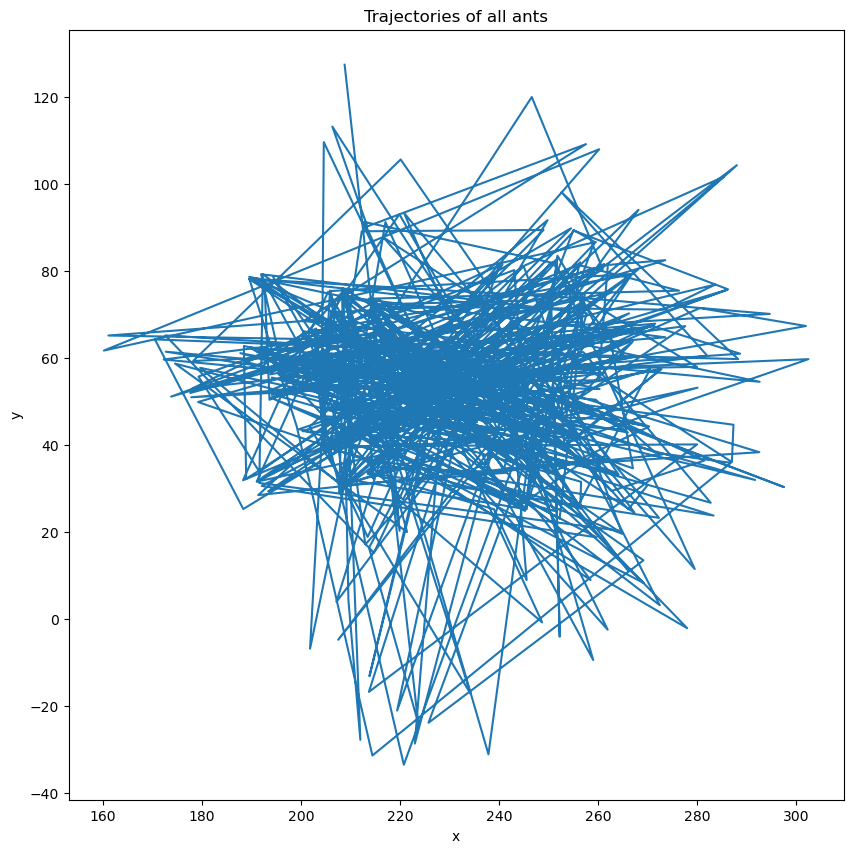

In [ ]:
# plot all ants trajectories in one plot with different colours
plt.figure(figsize=(10, 10))
for ant_id in df['ant_id'].unique()[:1]:
    ant_surrogate_x = pd.Series(surrogate_data.loc[surrogate_data['ant_id'] == ant_id, 'surrogate_positions_x'].values[0])
    ant_surrogate_y = pd.Series(surrogate_data.loc[surrogate_data['ant_id'] == ant_id, 'surrogate_positions_y'].values[0])
    plt.plot(ant_surrogate_x, ant_surrogate_y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories of all ants')
plt.show()